# Chapter 5: Splines

In [ ]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
from patsy import bs, dmatrix

In [2]:
az.style.use('arviz-grayscale')
plt.rcParams["figure.dpi"] = 300
np.random.seed(435)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0),
            (0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 0.5),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 0.5),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 0.5),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 0.5),
            (0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 0.3),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 0.3),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 0.3),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 0.3)]

In [3]:
x = np.random.normal(0.5, 1, 50)
y = np.random.normal(x**2, 1)

<ipython-input-4-dfe1078c7998>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0X" (-> color=(0.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  ax.plot(x[0], y[0], 'C0X', color="C4")
<ipython-input-4-dfe1078c7998>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0X" (-> color=(0.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  ax.plot(x[0], y[0], 'C0X', color="C4")
<ipython-input-4-dfe1078c7998>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0X" (-> color=(0.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  ax.plot(x[0], y[0], 'C0X', color="C4")


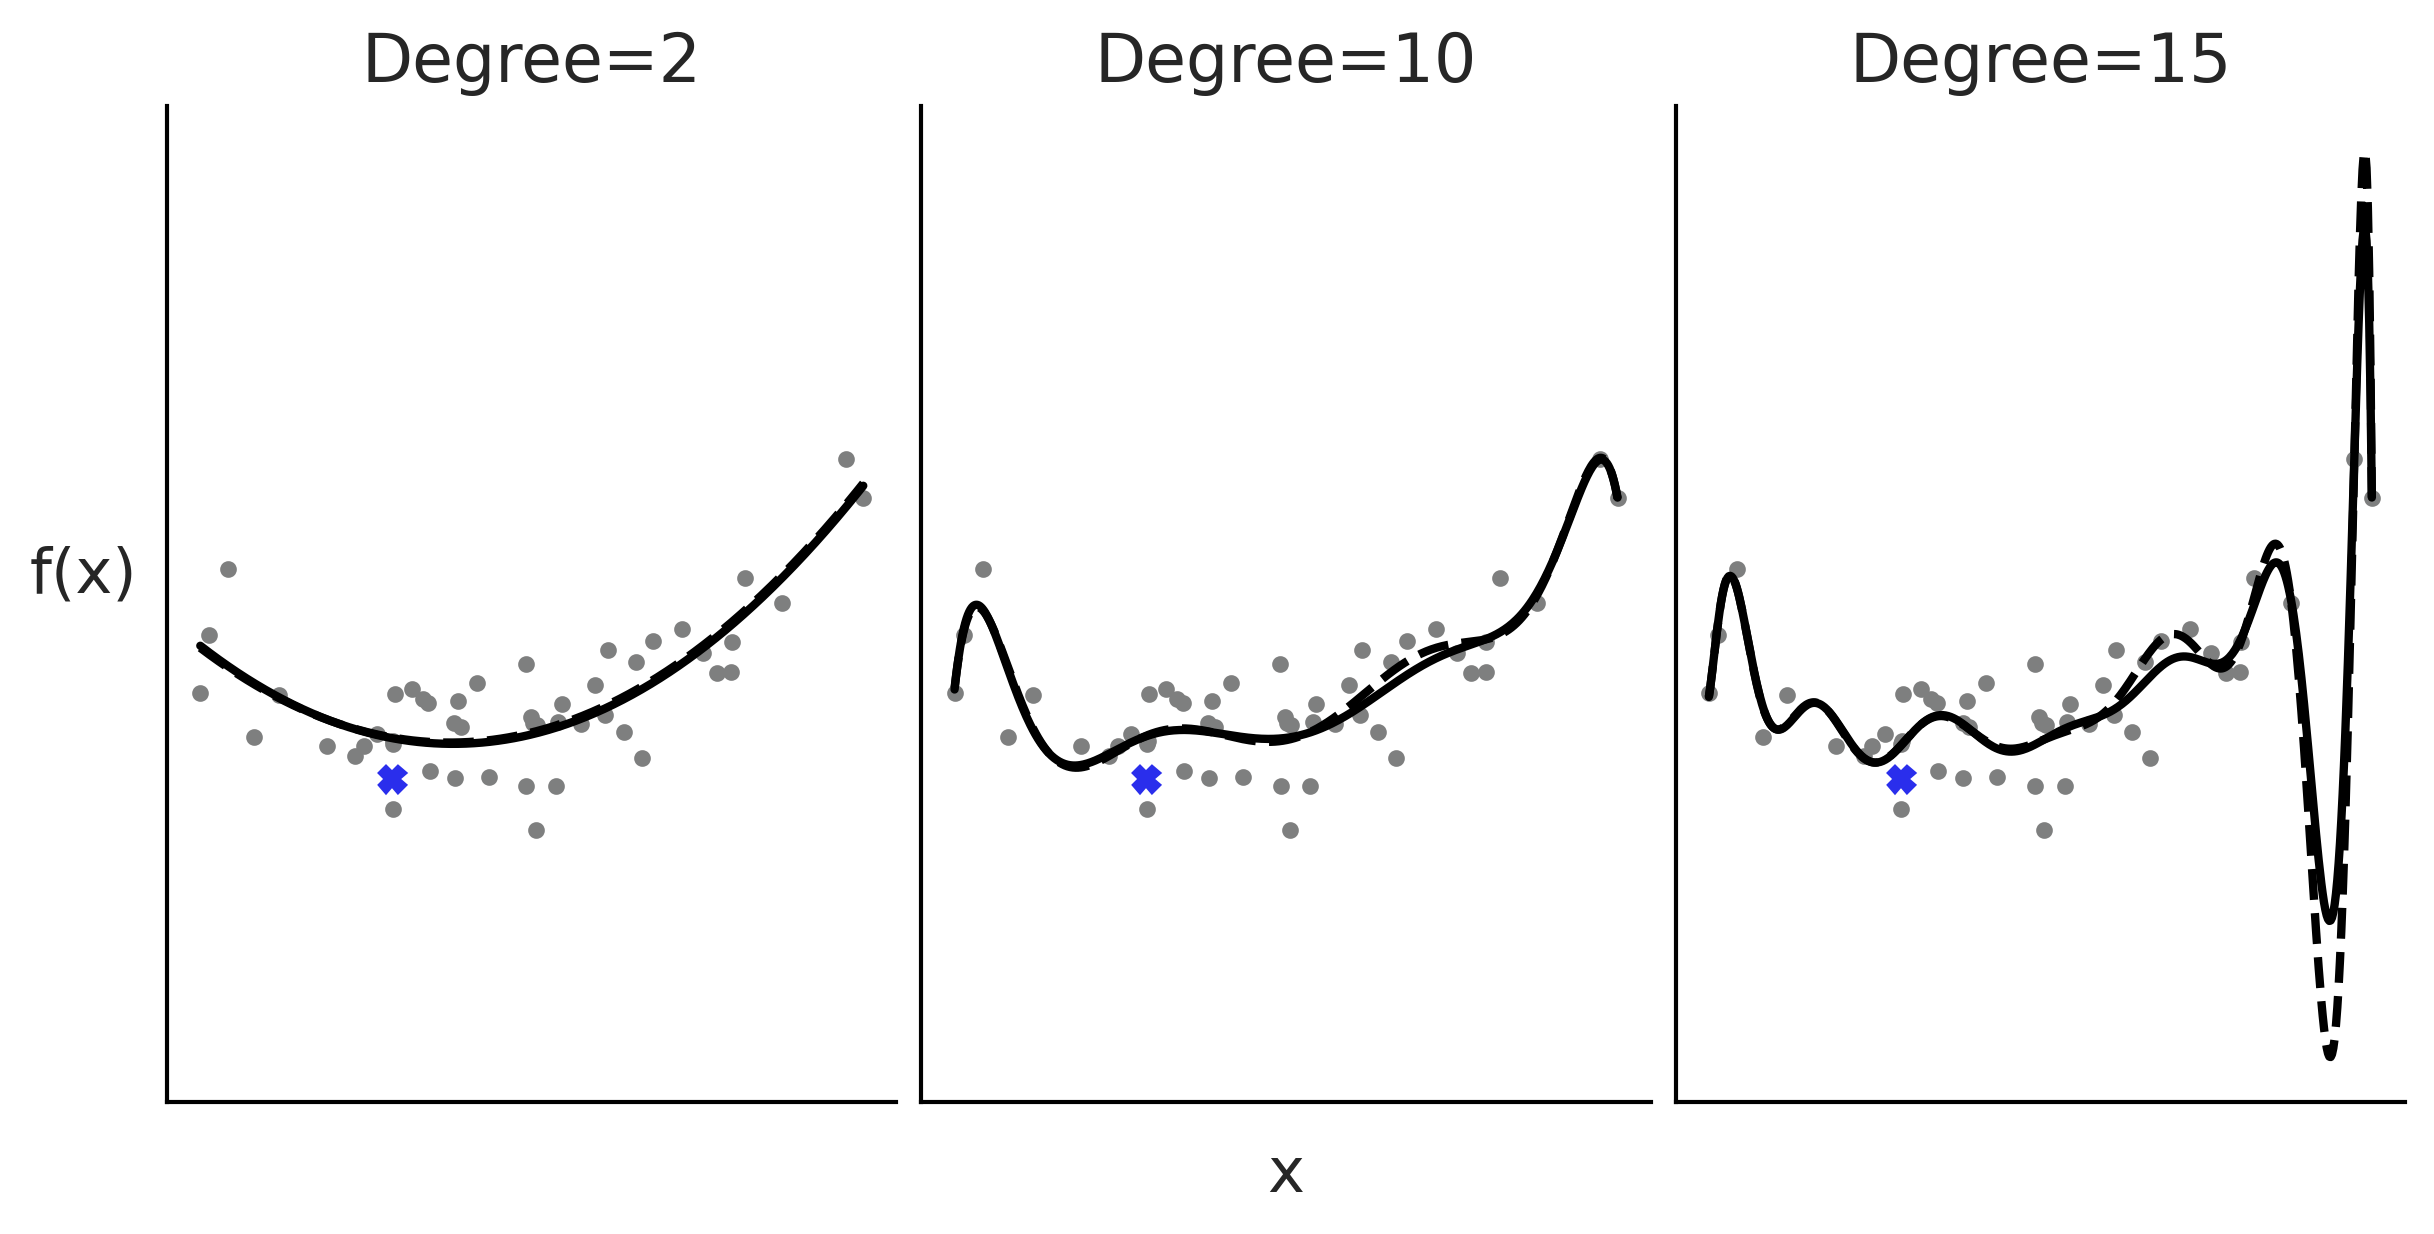

In [4]:
x_ = np.linspace(x.min(), x.max(), 500)


_, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

for deg, ax in zip([2, 10, 15], axes):
    ax.plot(x, y, 'C2.')
    ax.set_title(f"Degree={deg}")
    coefs = np.polyfit(x, y, deg=deg)
    ffit = np.poly1d(coefs)
    ax.plot(x_, ffit(x_), color="C0", lw=2)

    coefs = np.polyfit(x[:-1], y[:-1], deg=deg)
    ffit = np.poly1d(coefs)
    ax.plot(x_, ffit(x_), color="C0", lw=2, ls="--")
    ax.plot(x[0], y[0], 'C0X', color="C4")


axes[1].set_xlabel("x", labelpad=10)
axes[0].set_ylabel("f(x)", rotation=0, labelpad=20)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("img/chp05/polynomial_regression.png")

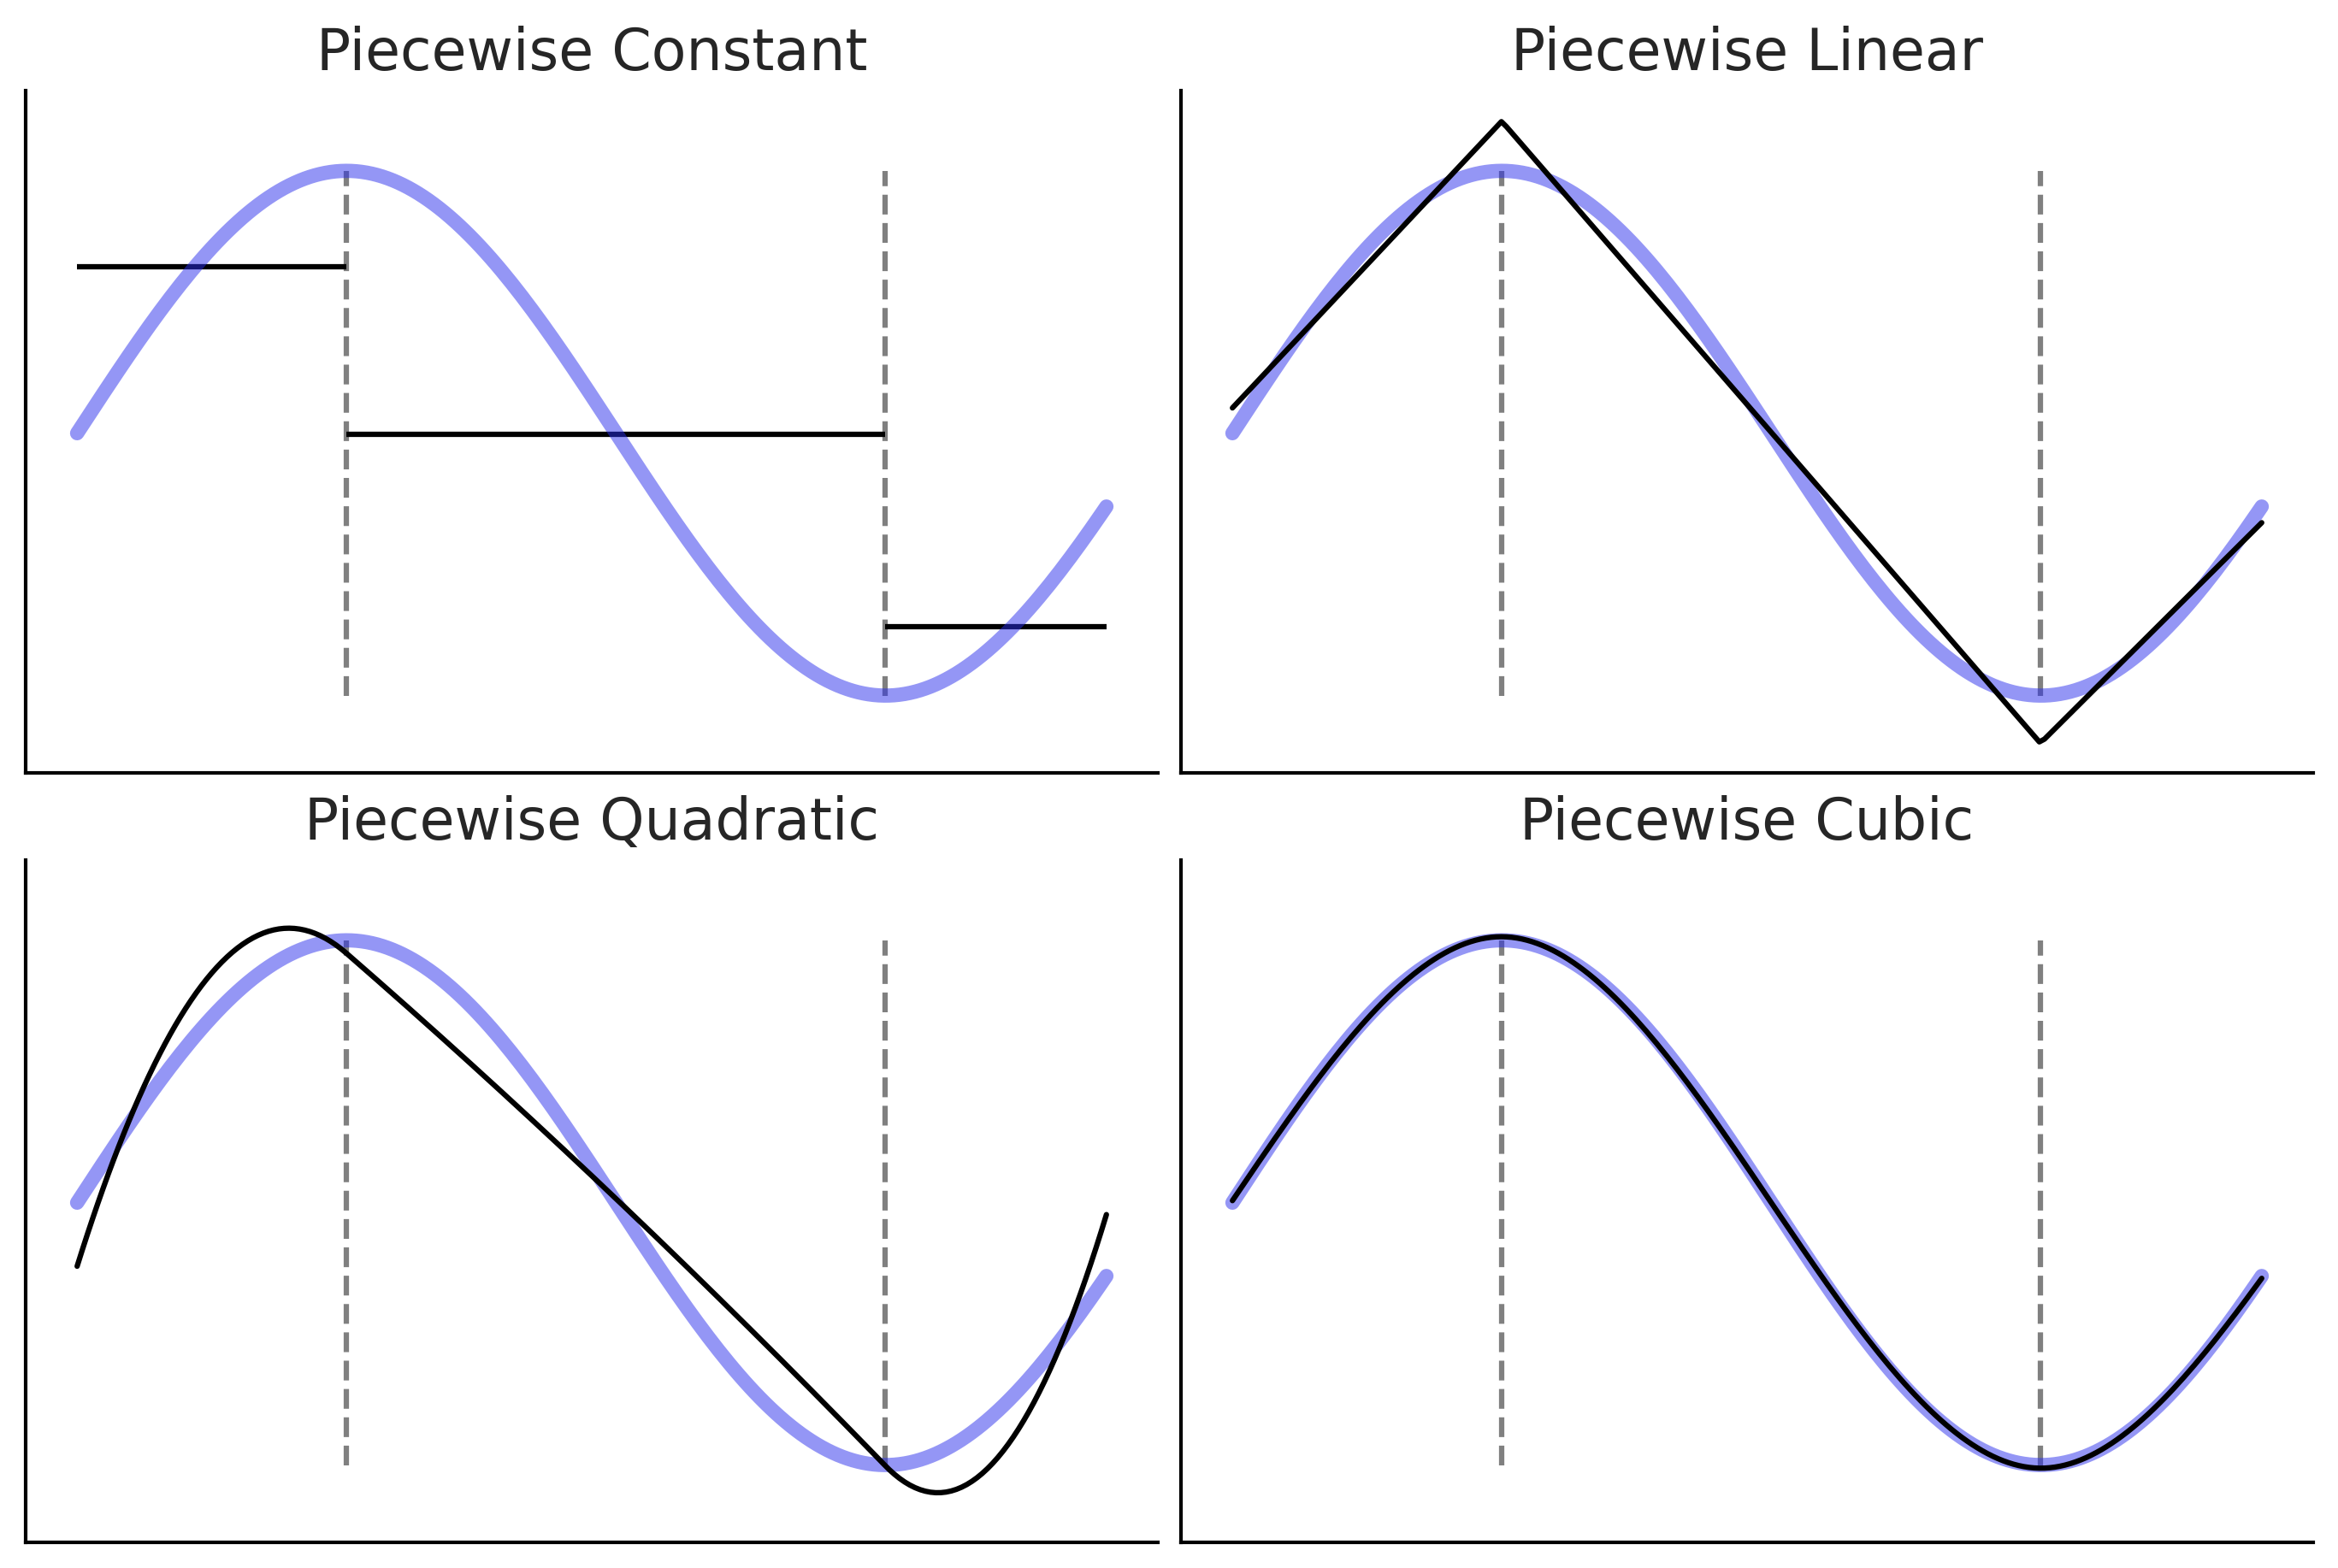

In [5]:
%run -i 'scripts/splines.py'

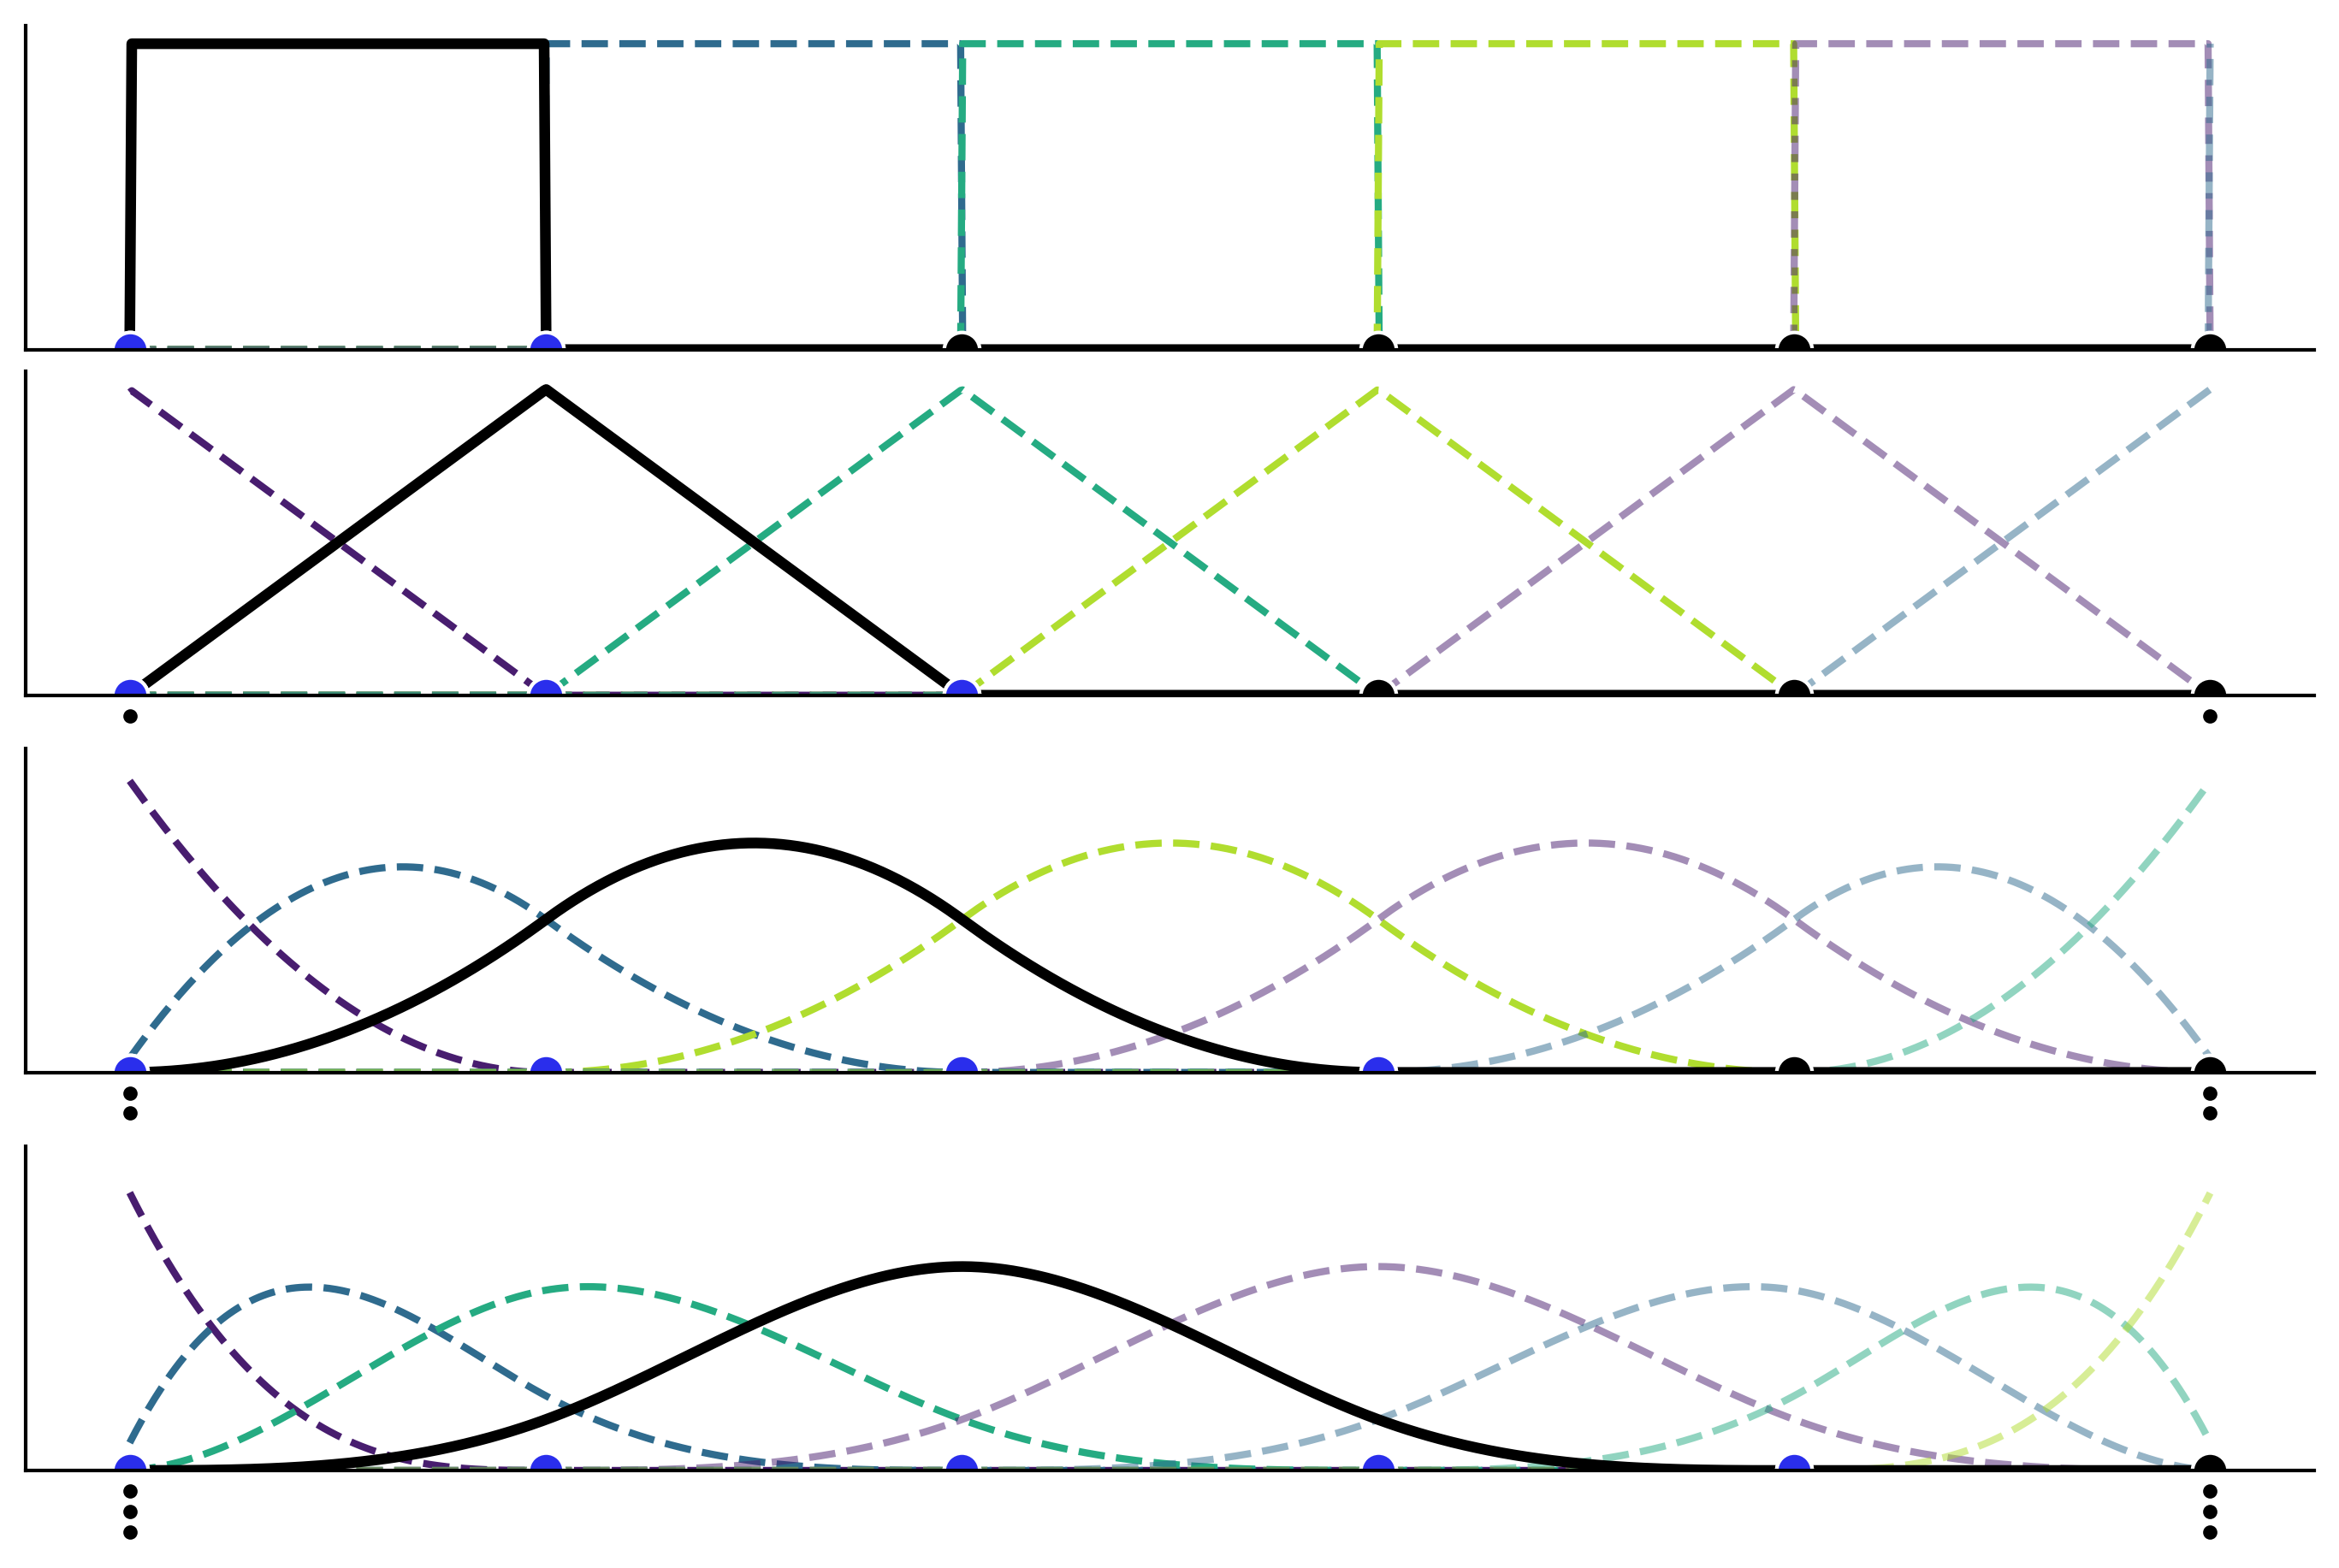

In [6]:
x = np.linspace(-0.0001, 1, 1000)
knots = [0, 0.2, 0.4, 0.6, 0.8, 1]

_, axes = plt.subplots(4, 1, figsize=(9, 6), sharex=True, sharey=True)
for deg, ax in enumerate(axes):
    b_splines = bs(x, degree=deg, knots=knots, lower_bound=-0.01, upper_bound=1.01)
    for enu, b_s in enumerate(b_splines.T):
        ax.plot(x, b_s, color=viridish[enu], lw=2, ls="--")
    ax.plot(x, b_splines[:,deg], lw=3)
    ax.plot(knots, np.zeros_like(knots), "ko", mec="w", ms=10)
    for i in range(1, deg+1):
        ax.plot([0, 1], np.array([0, 0])-(i/15), "k.", clip_on=False)
    ax.plot(knots[:deg+2], np.zeros_like(knots[:deg+2]), "C4o", mec="w", ms=10)
plt.ylim(0)
plt.xticks([])
plt.yticks([]);
plt.savefig('img/chp05/splines_basis.png')

In [7]:
x = np.linspace(0., 1., 500)
knots = [0.25, 0.5, 0.75]

B0 = dmatrix("bs(x, knots=knots, degree=0, include_intercept=True) - 1", 
             {"x": x, "knots":knots})
B1 = dmatrix("bs(x, knots=knots, degree=1, include_intercept=True) - 1",
             {"x": x, "knots":knots})
B3 = dmatrix("bs(x, knots=knots, degree=3,include_intercept=True) - 1",
             {"x": x, "knots":knots})

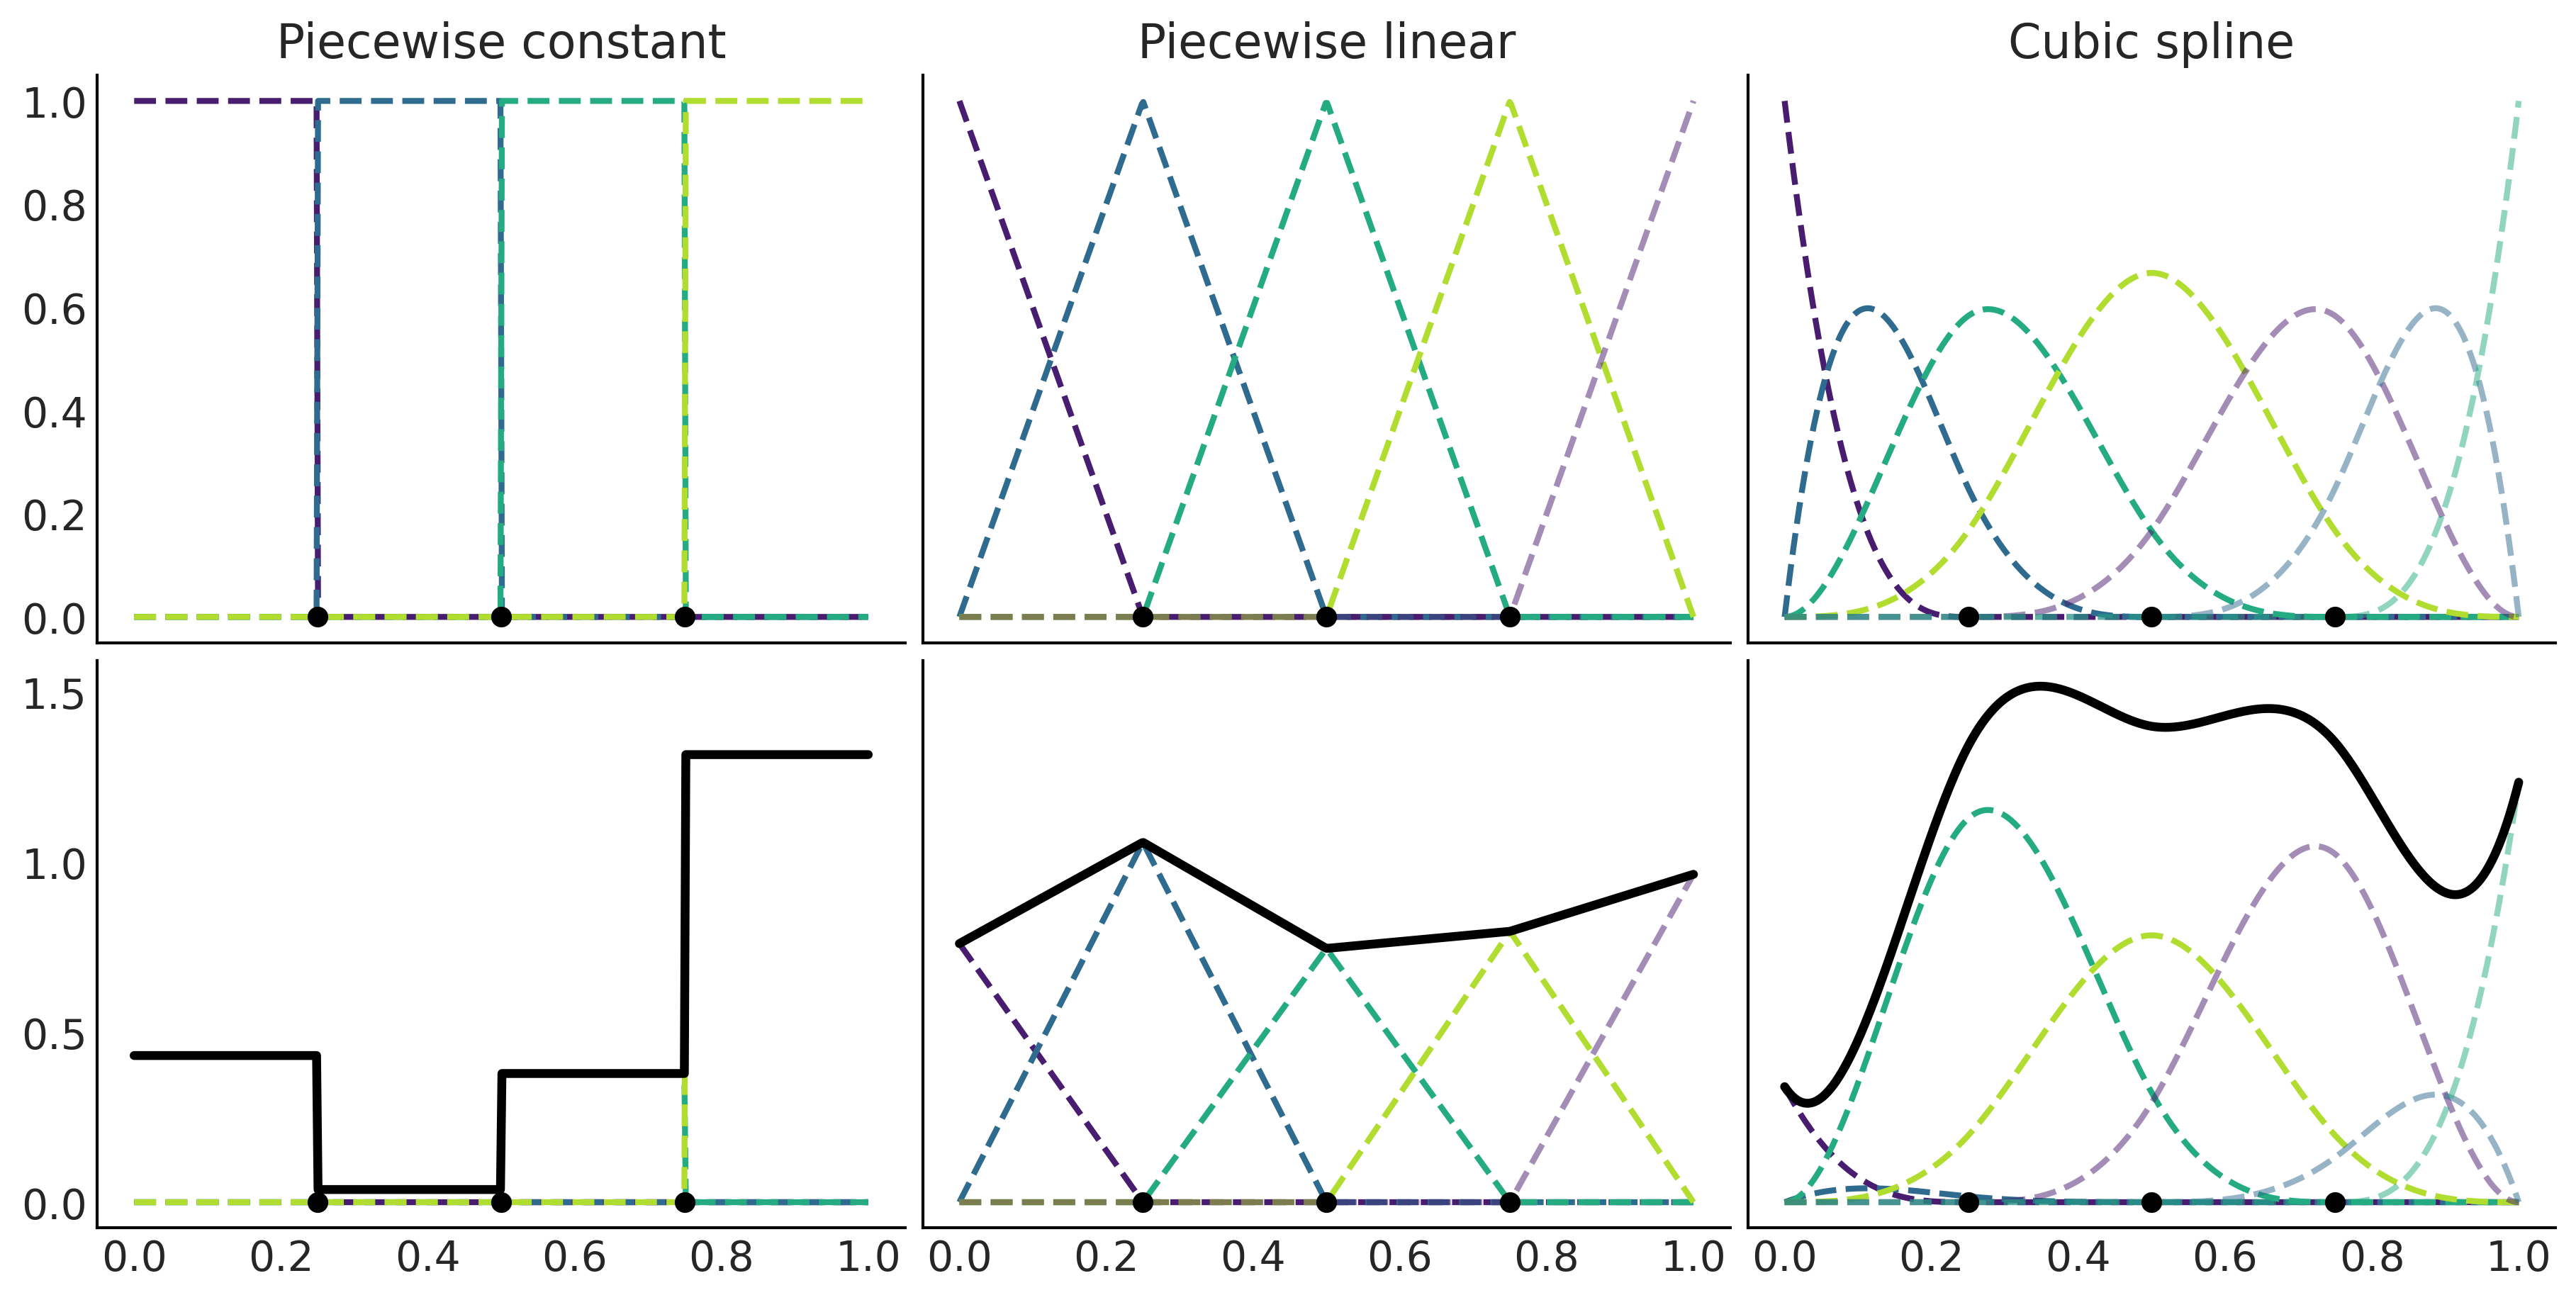

In [8]:
np.random.seed(1563)
_, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey='row')
for idx, (B, title) in enumerate(zip((B0, B1, B3),
                                     ("Piecewise constant",
                                      "Piecewise linear",
                                      "Cubic spline"))):
    # plot spline basis functions
    for i in range(B.shape[1]):
        axes[0, idx].plot(x, B[:, i],
                          color=viridish[i], lw=2, ls="--")
    # we generate some positive random coefficients 
    # there is nothing wrong with negative values
    β = np.abs(np.random.normal(0, 1, size=B.shape[1]))
    # plot spline basis functions scaled by its β
    for i in range(B.shape[1]):
        axes[1, idx].plot(x, B[:, i]*β[i],
                          color=viridish[i], lw=2, ls="--")
    # plot the sum of the basis functions
    axes[1, idx].plot(x, np.dot(B, β), color='k', lw=3)
    # plot the knots
    axes[0, idx].plot(knots, np.zeros_like(knots), "ko")
    axes[1, idx].plot(knots, np.zeros_like(knots), "ko")
    axes[0, idx].set_title(title)

plt.savefig('img/chp05/splines_weighted.png')

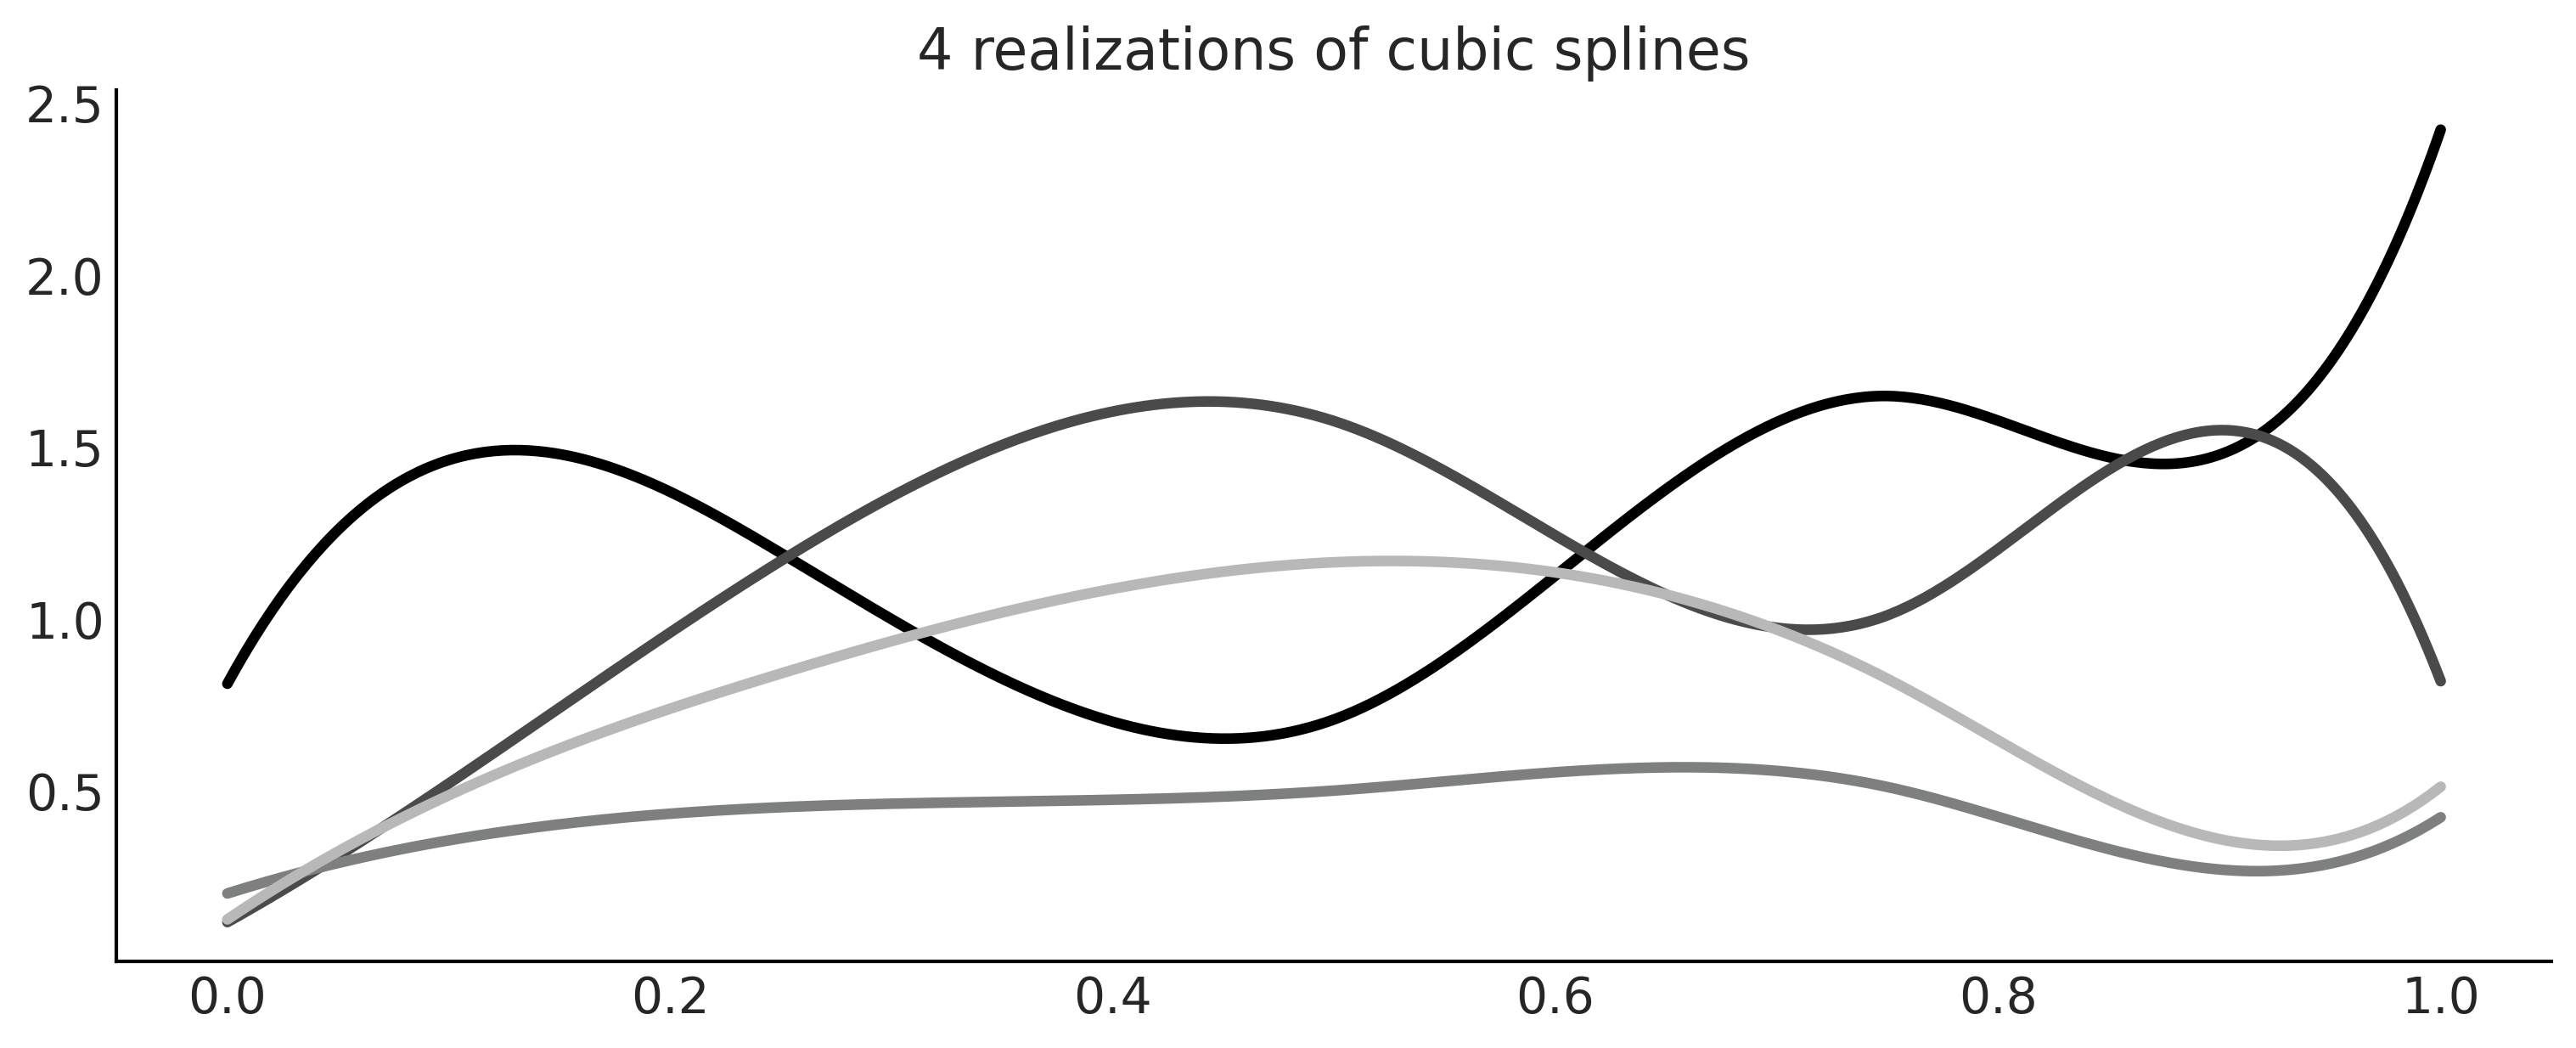

In [9]:
_, axes = plt.subplots(1, 1, figsize=(10, 4))

for i in range(4):
    β = np.abs(np.random.normal(0, 1, size=B.shape[1]))
    axes.plot(x, np.dot(B, β), color=f'C{i}', lw=3)
    axes.set_title("4 realizations of cubic splines")

plt.savefig('img/chp05/splines_realizations.png')

In [10]:
x = np.linspace(0., 1., 20)
knots = [0.25, 0.5, 0.75]

B0 = dmatrix("bs(x, knots=knots, degree=0, include_intercept=True) - 1", {"x": x, "knots":knots})
B1 = dmatrix("bs(x, knots=knots, degree=1, include_intercept=True) - 1", {"x": x, "knots":knots})
B3 = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True) - 1", {"x": x, "knots":knots})

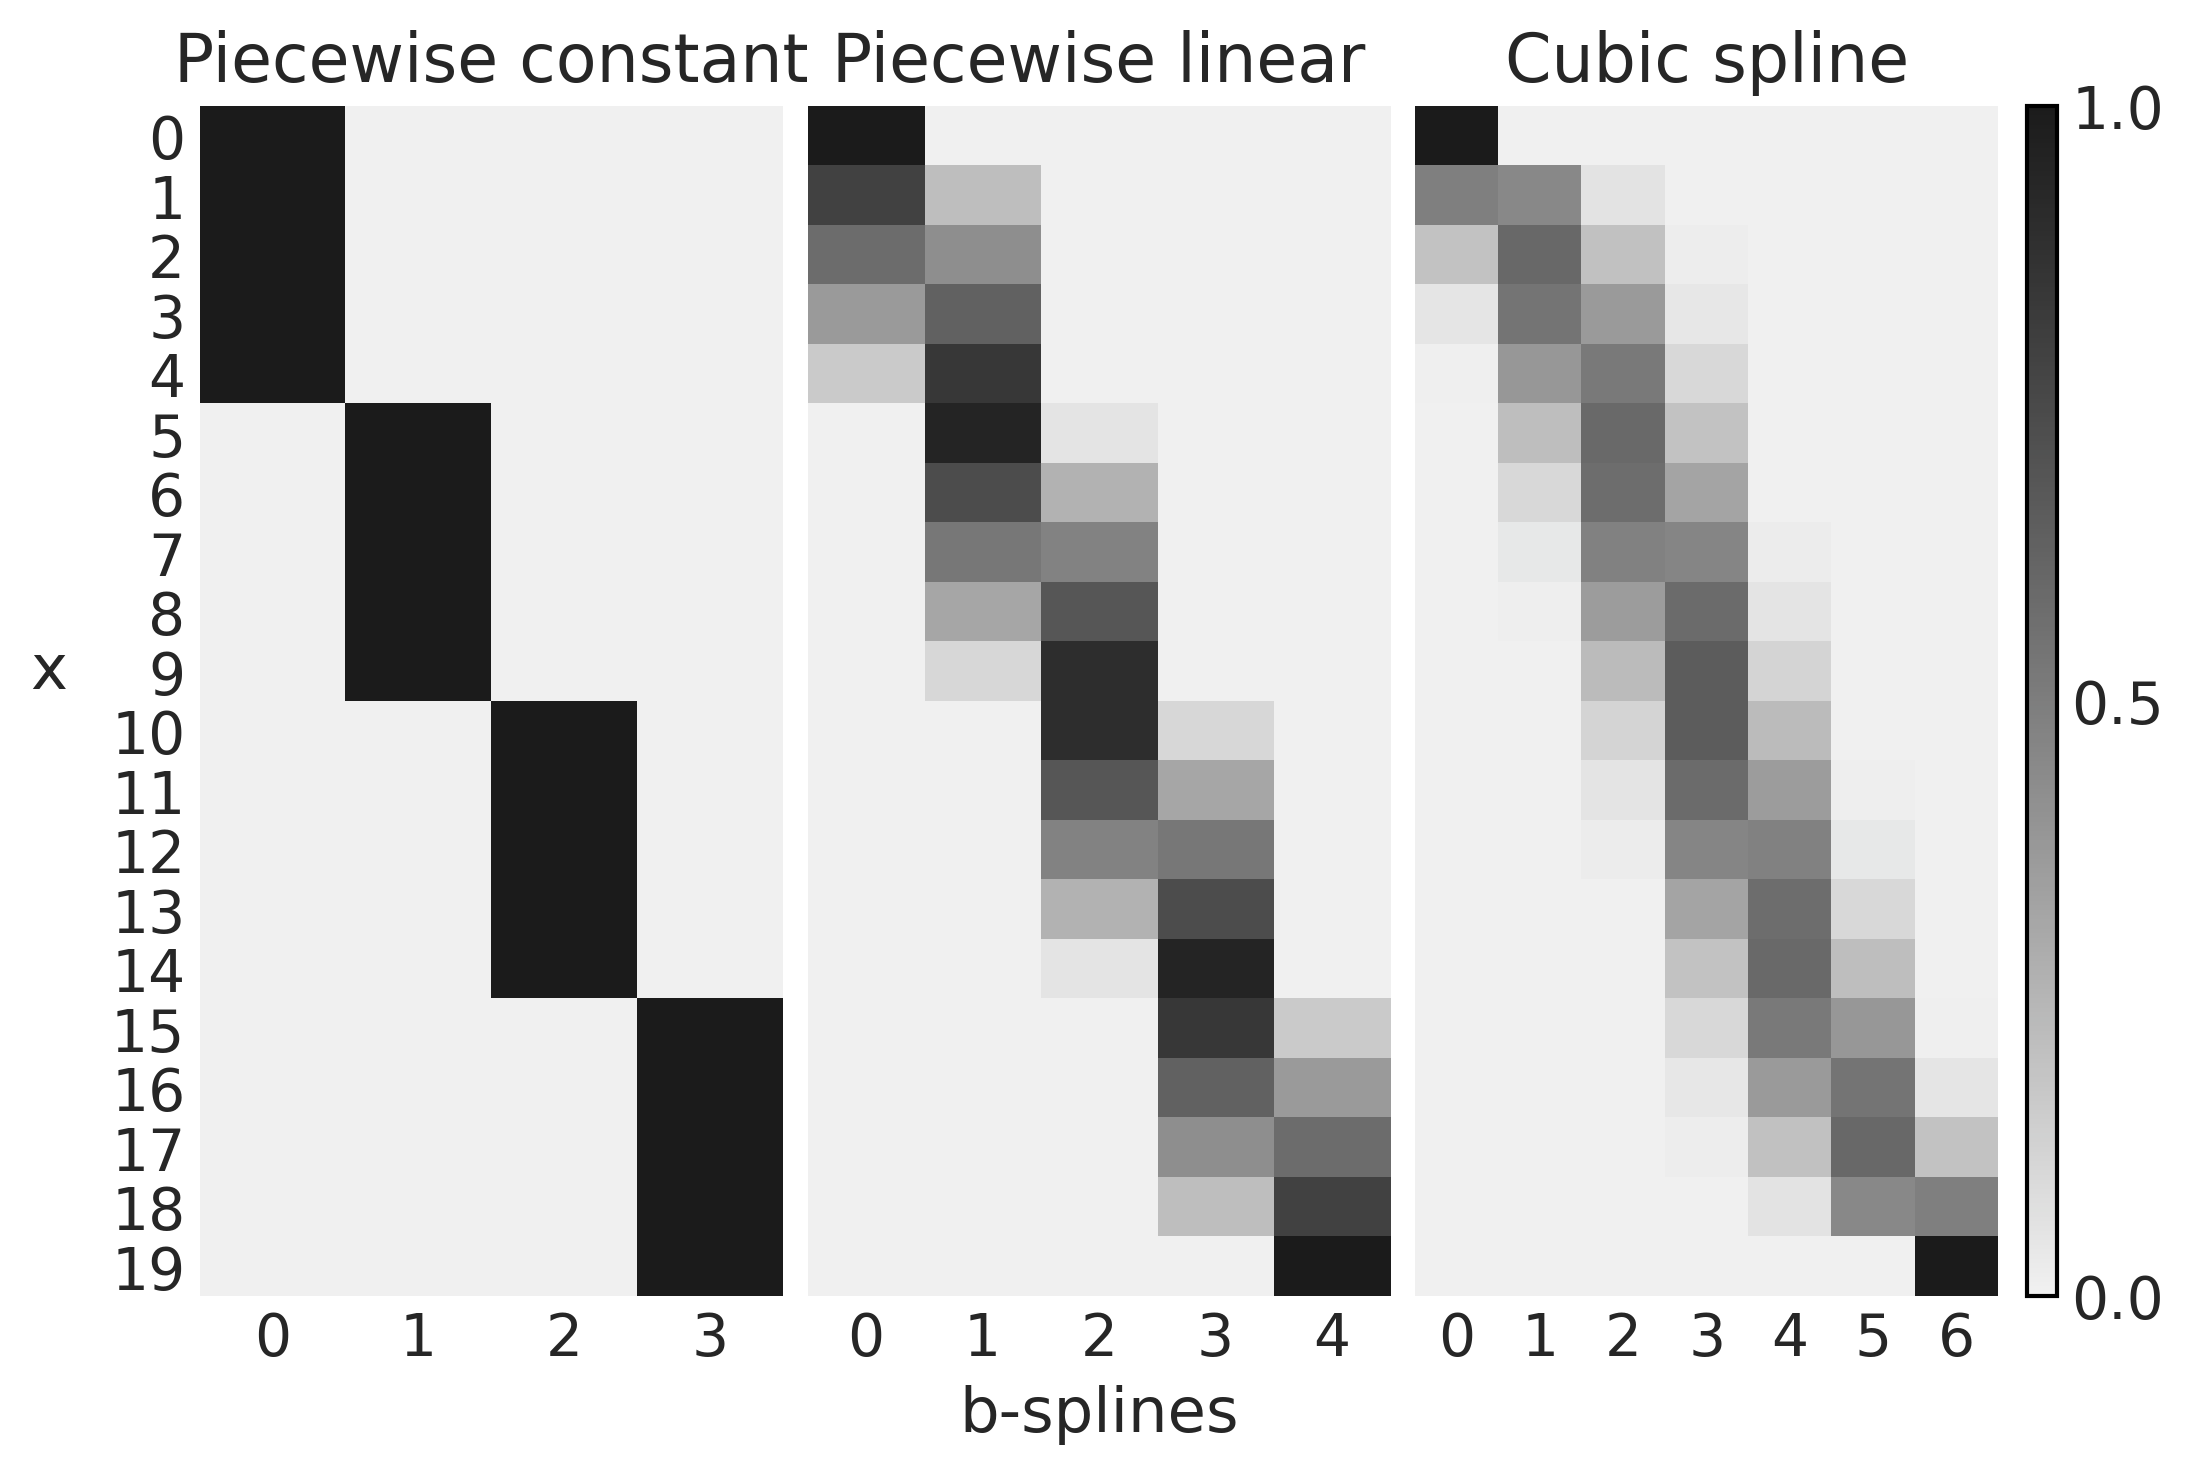

In [11]:
fig, axes = plt.subplots(1, 3, sharey=True)
for idx, (B, title, ax) in enumerate(zip((B0, B1, B3),
                                     ("Piecewise constant", 
                                      "Piecewise linear", 
                                      "Cubic spline"),
                                      axes)):
    cax = ax.imshow(B, cmap="cet_gray_r", aspect="auto")
    ax.set_xticks(np.arange(B.shape[1]))
    ax.set_yticks(np.arange(B.shape[0]))
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(title)


axes[1].set_xlabel("b-splines")
axes[0].set_ylabel("x", rotation=0, labelpad=15)
fig.colorbar(cax, aspect=40, ticks=[0, 0.5, 1])
plt.savefig('img/chp05/design_matrices.png')

In [12]:
data = pd.read_csv("../data/bikes_hour.csv")
data.sort_values(by="hour", inplace=True)

# We standardize the response variable
data_cnt_om = data["count"].mean()
data_cnt_os = data["count"].std()
data["count_normalized"] = (data["count"] - data_cnt_om) / data_cnt_os
# Remove data, you may later try to refit the model to the whole data
data = data[::50]

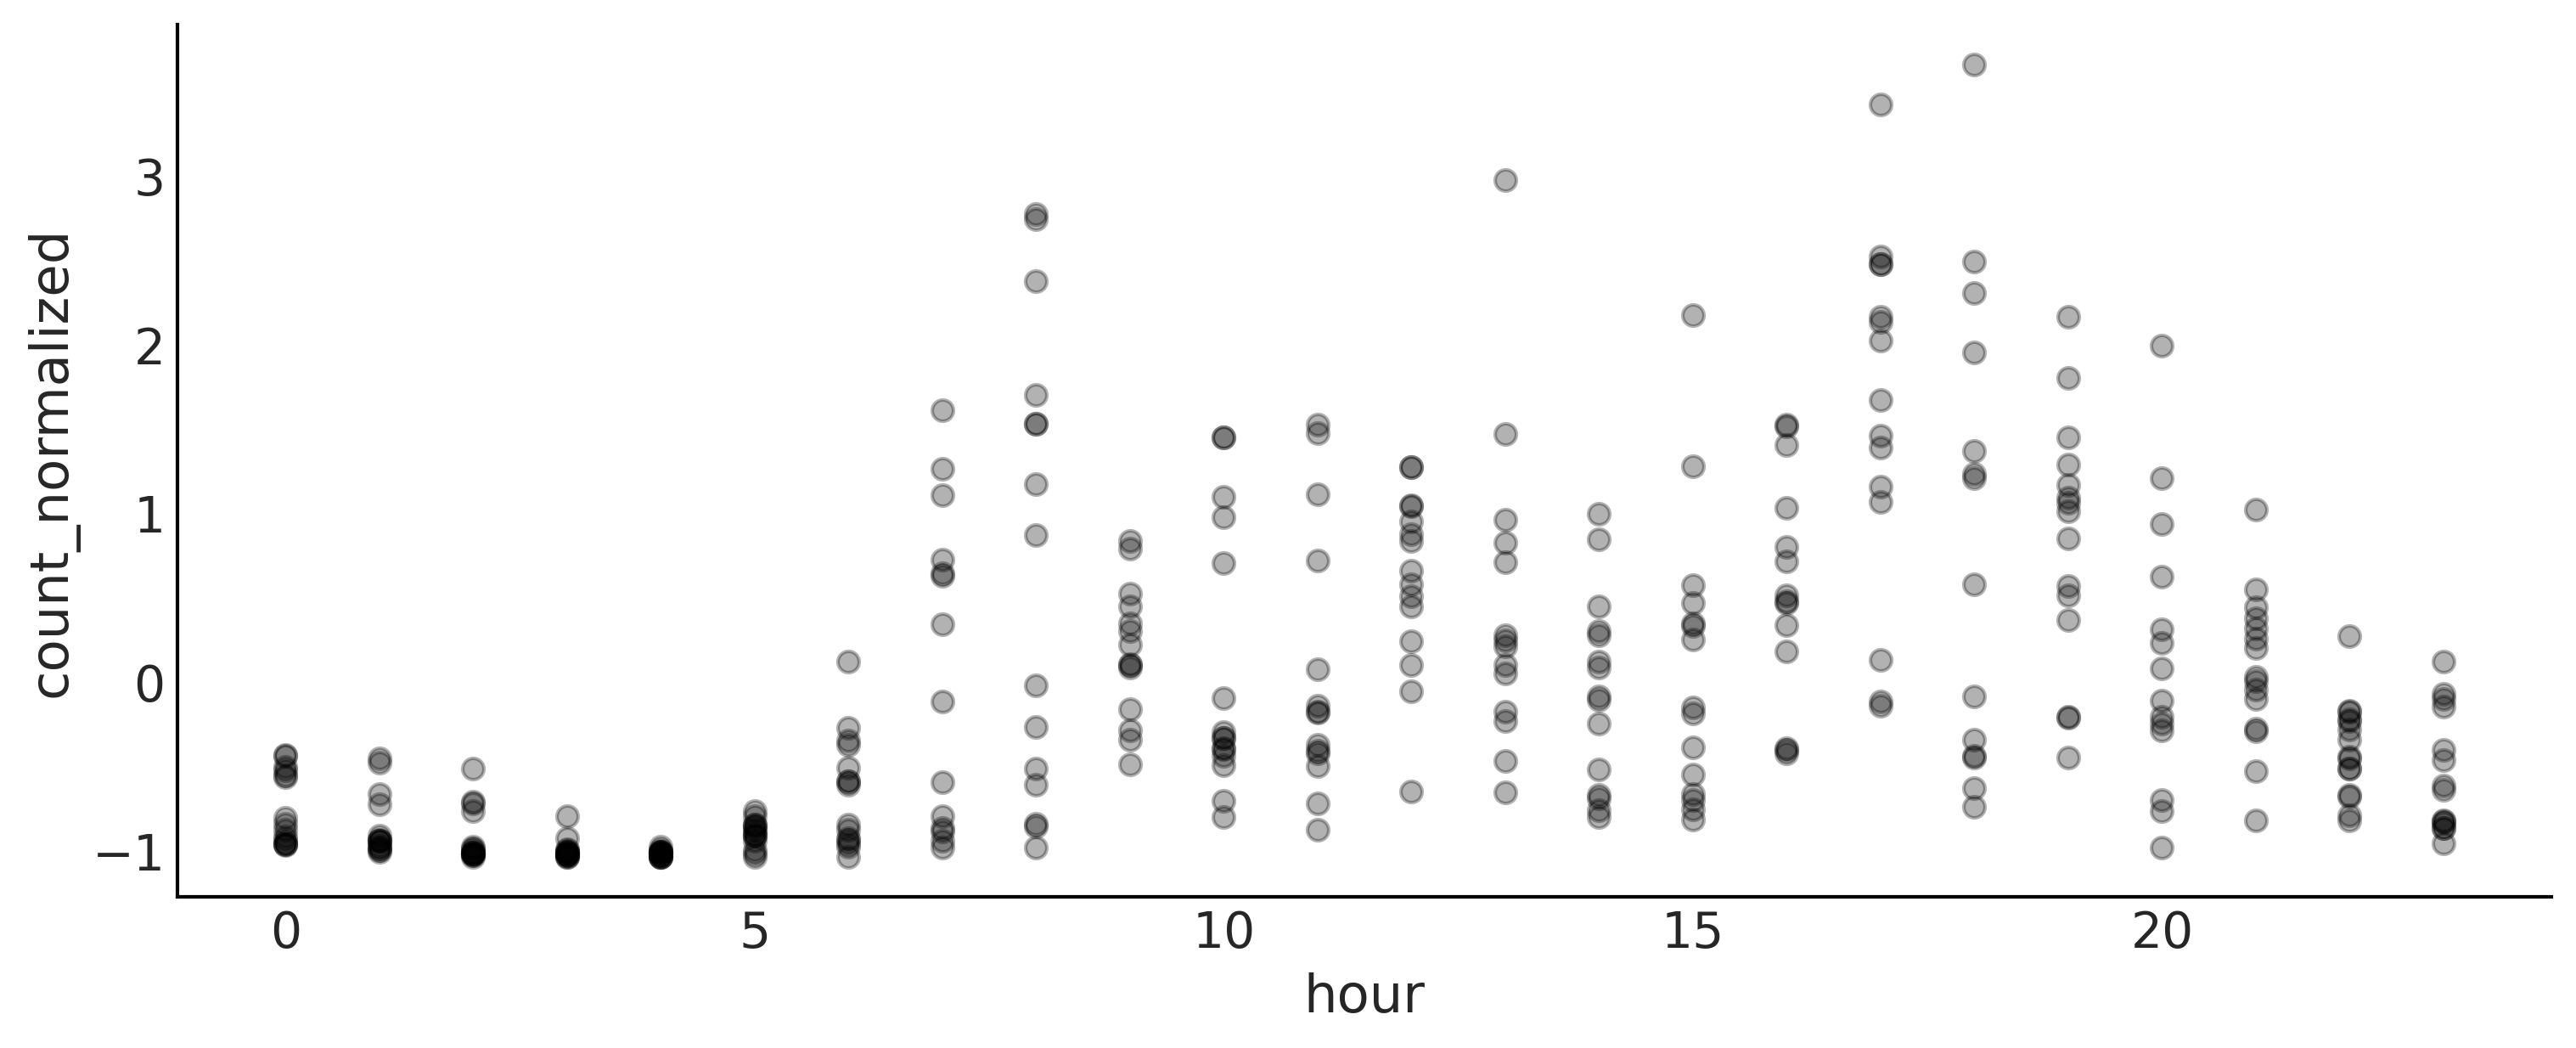

In [13]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data.hour, data.count_normalized, "o", alpha=0.3)
ax.set_xlabel("hour")
ax.set_ylabel("count_normalized")
plt.savefig('img/chp05/bikes_data.png');

In [14]:
num_knots = 6
knot_list = np.linspace(0, 23, num_knots)[1:-1]

In [15]:
B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list},
)

In [16]:
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idata_s = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [17]:
#az.summary(trace_splines, var_names=["~μ"], kind="stats")

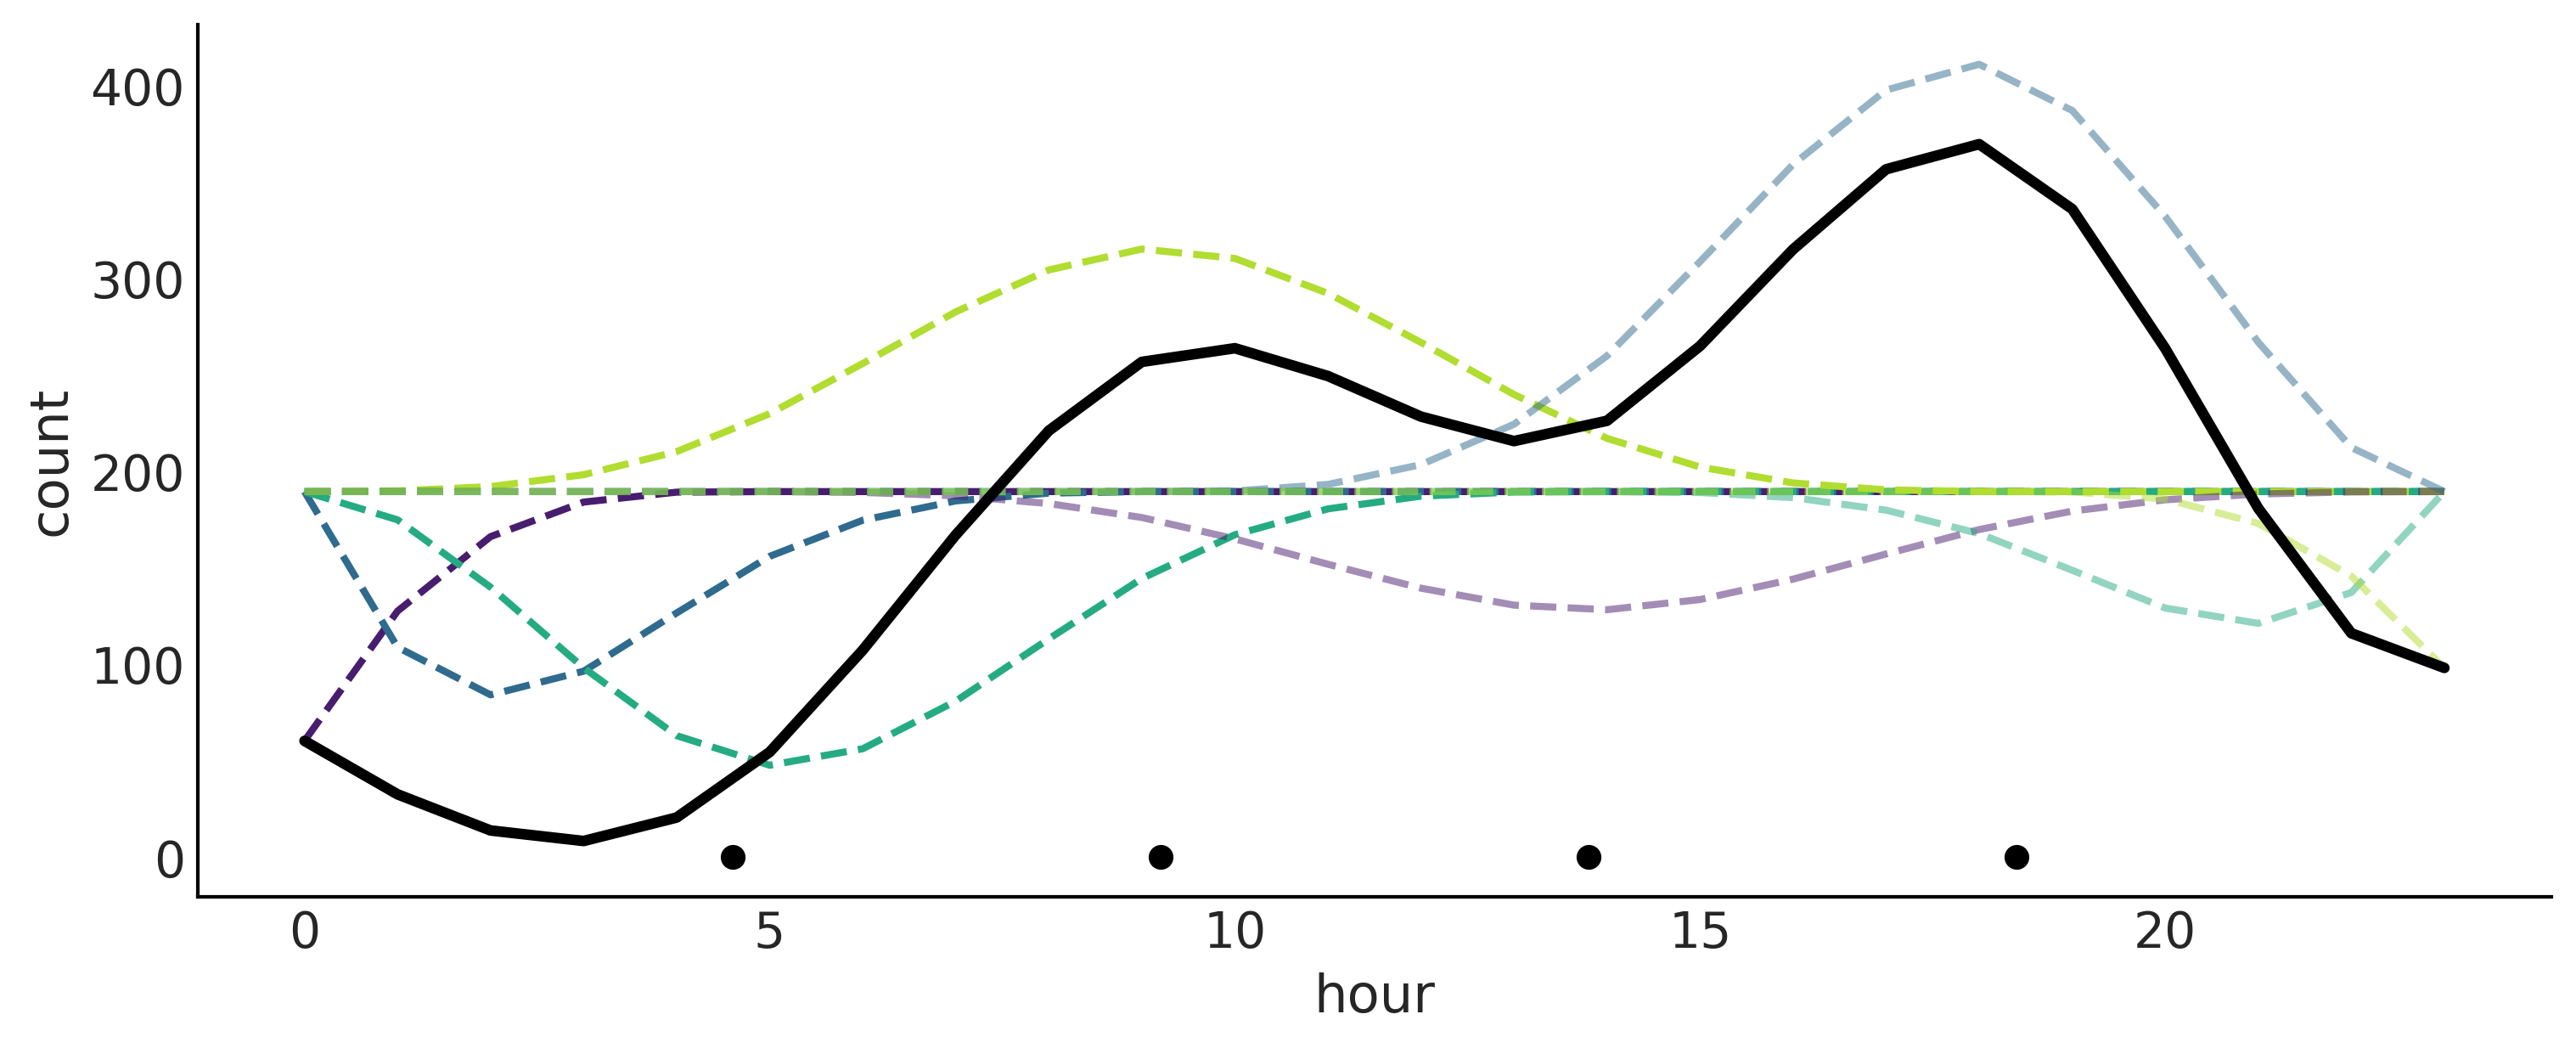

In [18]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_prop_cycle(cycler('color', viridish))
posterior = idata_s.posterior.stack(samples=['chain', 'draw'])
ax.plot(data.hour, (B*posterior["β"].mean("samples").values * data_cnt_os) + data_cnt_om, lw=2, ls='--')
ax.plot(data.hour, posterior["μ"].mean("samples") * data_cnt_os + data_cnt_om, 'k', lw=3)
ax.set_xlabel("hour")
ax.set_ylabel("count")
ax.plot(knot_list, np.zeros_like(knot_list), 'ko')
plt.savefig("img/chp05/bikes_spline_raw_data.png")

/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


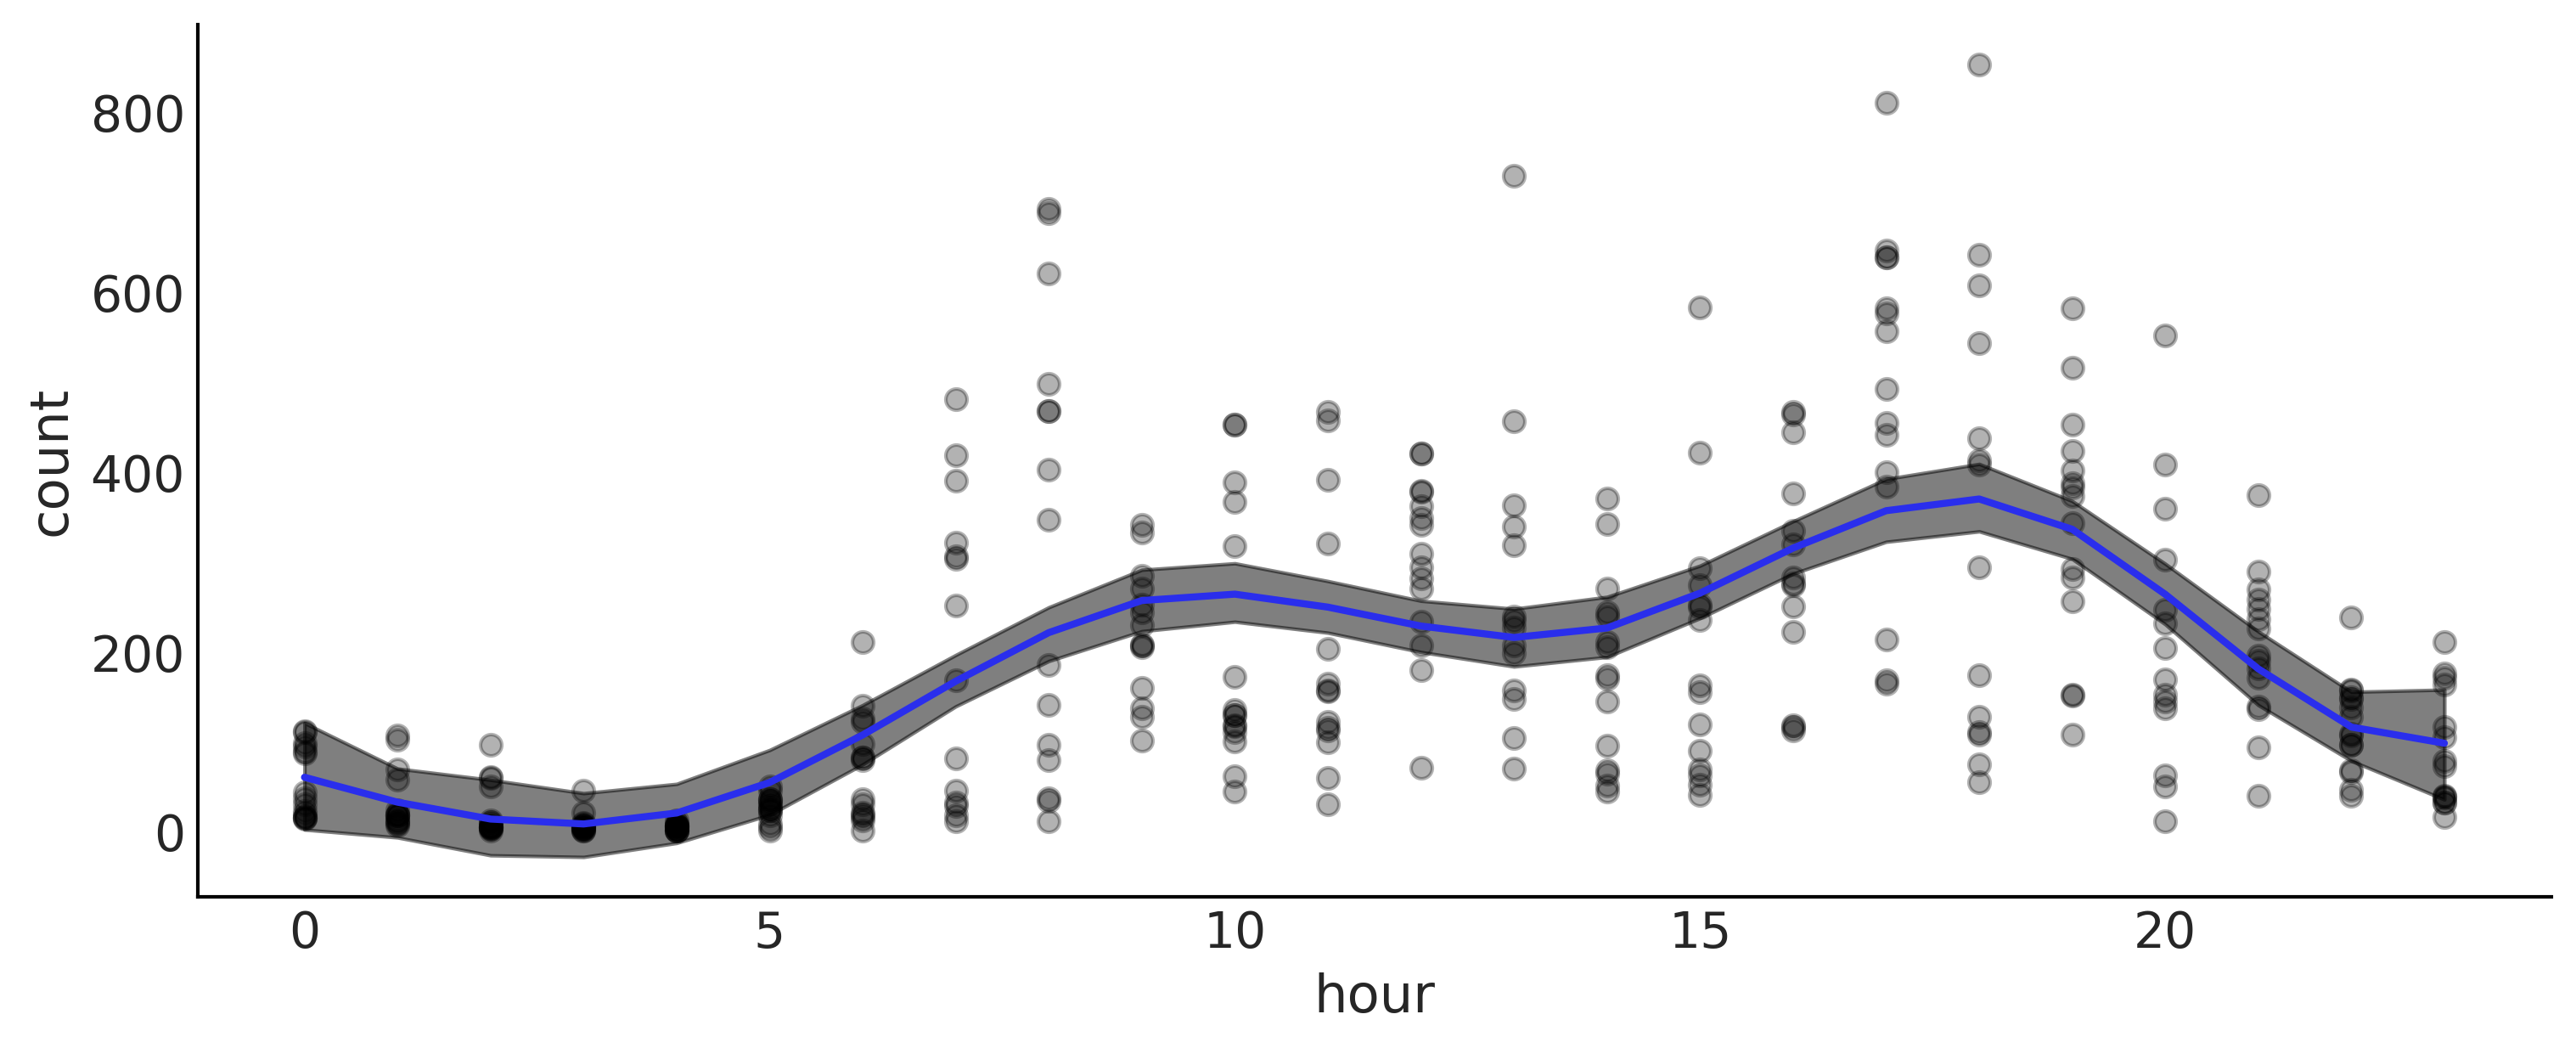

In [19]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(data.hour, data["count"], "o", alpha=0.3, zorder=-1)
# we use data_cnt_os and data_cnt_om to rescale the cnt data and results
ax.plot(data.hour, (posterior["μ"].mean("samples")  * data_cnt_os) + data_cnt_om, color="C4", lw=2)
az.plot_hdi(data.hour, (posterior["μ"].T  * data_cnt_os) + data_cnt_om,
            color="C0", smooth=False)
ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_data.png")

## Using LOO to choose the number of knots

In [20]:
Bs = []

num_knots = (3, 6, 9, 12, 18)
for nk in num_knots:
    knot_list = np.linspace(0, 24, nk+2)[1:-1]
    B = dmatrix(
        "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
        {"cnt": data.hour.values, "knots": knot_list},
    )
    Bs.append(B)

In [21]:
idatas = []
for B in Bs:
    with pm.Model() as splines:
        τ = pm.HalfCauchy('τ', 1) 
        β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
        μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
        σ = pm.HalfNormal("σ", 1)
        c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
        idata = pm.sample(1000, return_inferencedata=True)
        idatas.append(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [22]:
dict_cmp = {f"m_{k}k":v for k,v in zip(num_knots, idatas)}
cmp = az.compare(dict_cmp)
cmp.round(2)

/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_12k,0,-377.43,13.90,0.00,0.89,17.88,0.00,False,log
m_18k,1,-379.81,17.58,2.38,0.00,17.87,1.51,False,log
m_9k,2,-380.62,11.47,3.19,0.00,18.10,2.97,False,log
m_6k,3,-389.35,9.29,11.92,0.00,18.10,5.68,False,log
m_3k,4,-400.30,7.23,22.87,0.11,18.01,7.76,False,log


In [23]:
#print(cmp.round(2).to_latex())

<AxesSubplot:xlabel='Log'>

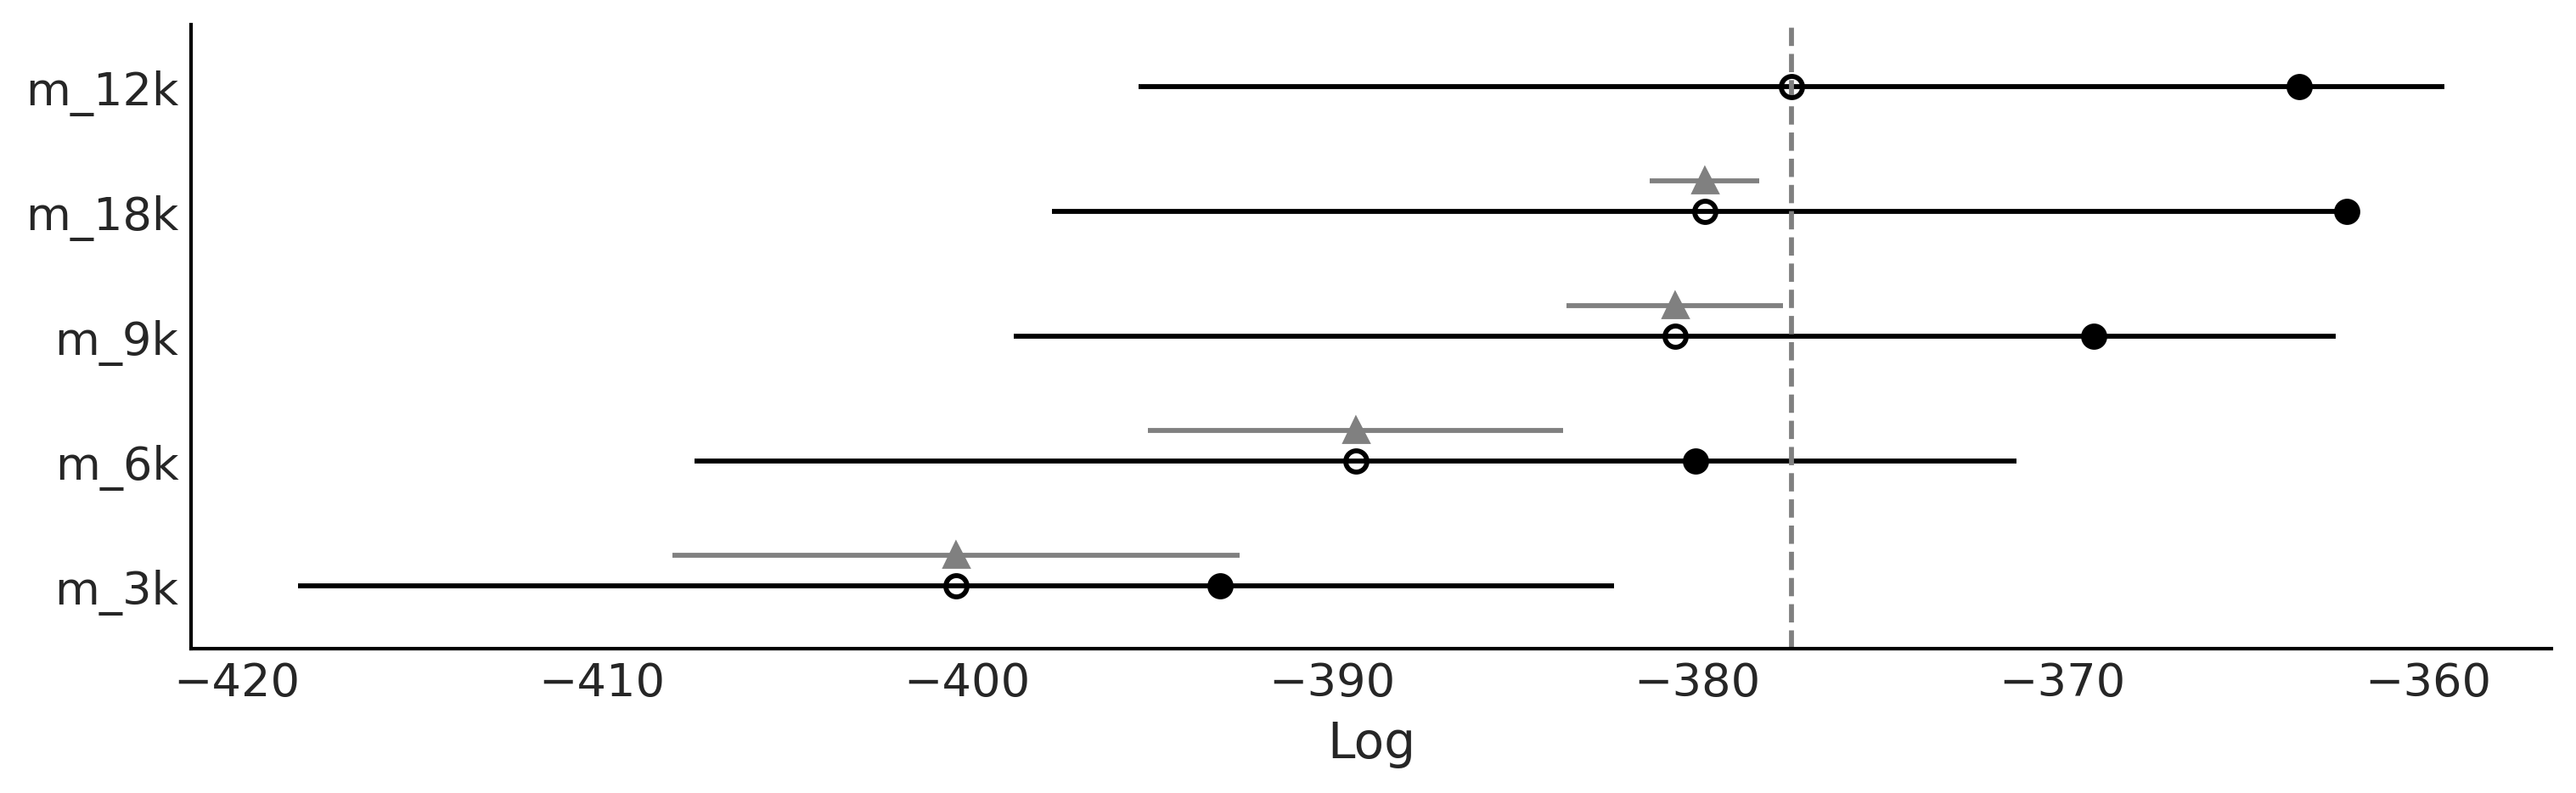

In [24]:
az.plot_compare(cmp, figsize=(10, 3))

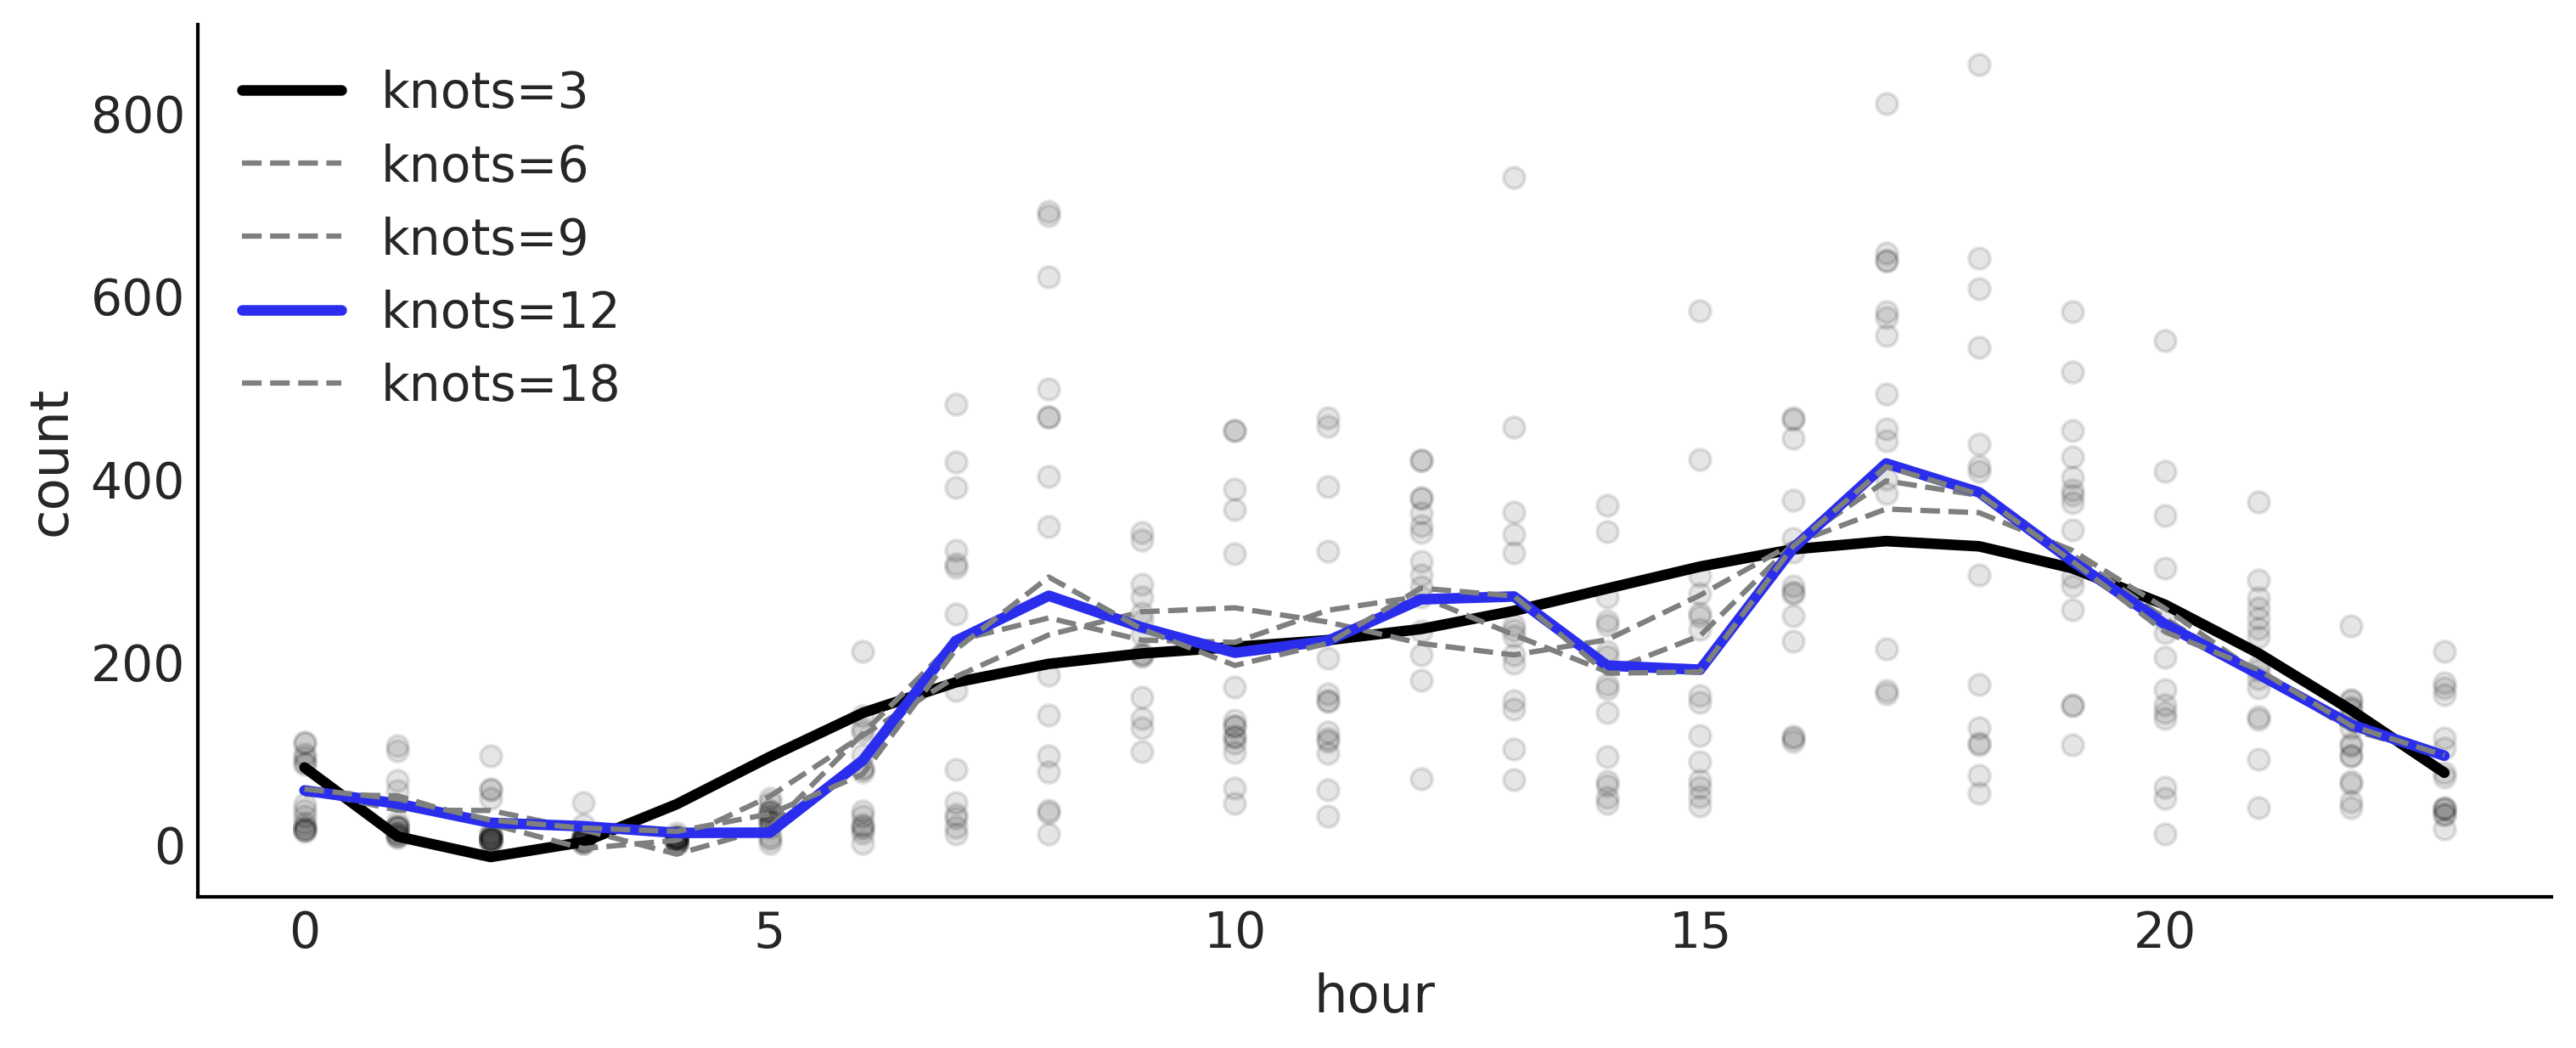

In [25]:
_, ax = plt.subplots(figsize=(10, 4))
ax.plot(data.hour, data["count"], "o", alpha=0.1, zorder=-1)

for idx, (idata, i, ls, lw) in enumerate(zip(idatas, (0,2,2,4,2), ("-","--","--","-","--"), (3,1.5,1.5,3,1.5))):
    mean_f = idata.posterior["μ"].mean(dim=['chain', 'draw'])
    ax.plot(data.hour,
            (mean_f * data_cnt_os) + data_cnt_om, color=f"C{i}",
            label=f"knots={(3, 6, 9, 12, 18)[idx]}" ,
            ls=ls, lw=lw)

plt.legend()
ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_loo_knots.png")

In [26]:
knot_list = np.arange(1, 23)

In [27]:
B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list},
)

In [28]:
with pm.Model() as wiggly:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    trace_wiggly = pm.sample(1000)
    idata_wiggly = az.from_pymc3(trace=trace_wiggly,
                                 posterior_predictive=pm.sample_posterior_predictive(trace_wiggly))

<ipython-input-28-fe357dbaa105>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_wiggly = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [29]:
with pm.Model() as splines_rw:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.GaussianRandomWalk("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    trace_splines_rw = pm.sample(1000)
    idata_splines_rw = az.from_pymc3(trace=trace_splines_rw,
                                 posterior_predictive=pm.sample_posterior_predictive(trace_splines_rw))

<ipython-input-29-bc97d60b5056>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_splines_rw = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


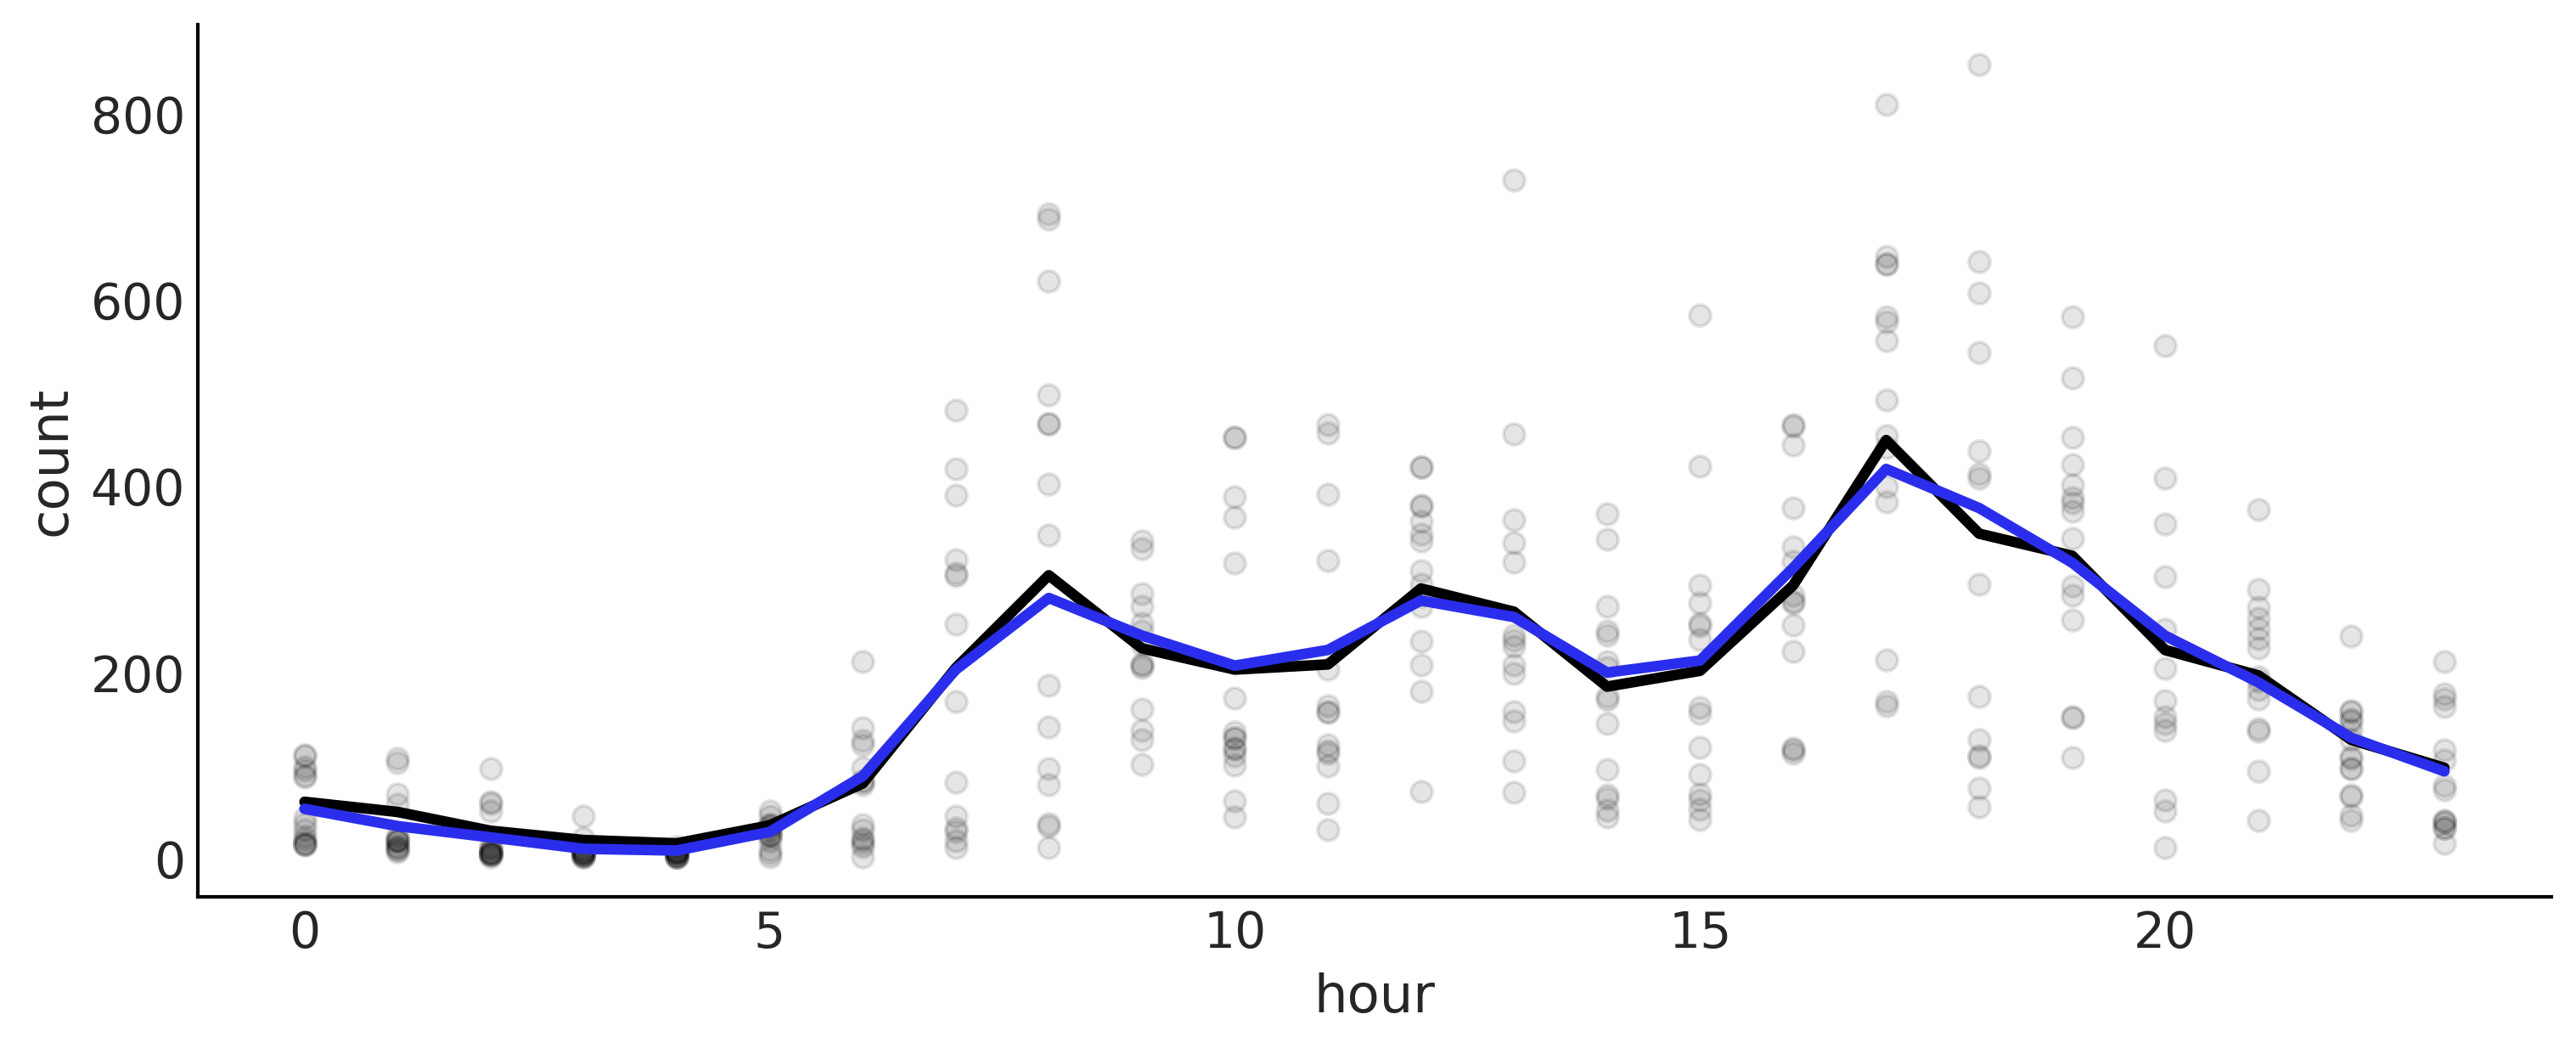

In [30]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(data.hour, data["count"], "o", alpha=0.1, zorder=-1)

wiggly_posterior = (idata_wiggly.posterior["μ"] * data_cnt_os) + data_cnt_om
mean_f = wiggly_posterior.mean(dim=['chain', 'draw'])
ax.plot(data.hour, mean_f , color="C0", lw=3)
#az.plot_hdi(data.hour, wiggly_posterior, smooth=False, color="C0")

splines_rw = (idata_splines_rw.posterior["μ"] * data_cnt_os) + data_cnt_om
mean_f = splines_rw.mean(dim=['chain', 'draw'])
ax.plot(data.hour, mean_f, color="C4", lw=3)
#az.plot_hdi(data.hour, splines_rw, smooth=False, color="C4")

ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_data_grw.png")